# Regression-Based Network Load Forecasting for Sustainable Digital Infrastructure
notebook 1

## Table of Contents
- [Сontext & EDA Goals](#contex-eda-goals)
- [Dataset overview and sanity snapshots](#dataset-overview-and-sanity-snapshots)
- [Target distribution & peak behaviour](#target-distribution-peak-behaviour)
- [Data Quality Analysis](#data-quality-analysis)
- [EDA Conclusions](#eda-conclusions)
- [Feature Engineering Plan](#feature-engineering-plan)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/data/data_merged.csv") # change to your path

## <a id="contex-eda-goals"></a>Сontext & EDA Goals

### Project context
This project uses real operational monitoring data from a data center network edge (one router and the infrastructure behind it).  
We observe hourly traffic on two active upstream uplinks (two different providers), plus CPU utilization from three backend hosts and monthly business proxy metrics (new VMs and new users).

The goal is to build an hourly forecasting model that helps anticipate short-term peak bandwidth demand. This can support better operational decisions (e.g., capacity planning, scheduling heavy jobs into lower-traffic windows) and reduce unnecessary overprovisioning.

### Target definition
**Primary target (forecasted 1 hour ahead):** `target_max_io_bps`  
- `target_max_io_bps = max(total_in_max_bps, total_out_max_bps)`  
- where:
  - `total_in_max_bps = u216_in_max + u220_in_max`
  - `total_out_max_bps = u216_out_max + u220_out_max`

**Secondary representation (same signal, different scale):** `target_max_io_util`  
- computed as `bps / total_capacity_bps`, where total capacity is `2 × 10 Gbps`

### Why 95th percentile matters (billing vs forecasting)
Network providers often bill based on the **95th percentile** traffic level over a billing window (typically monthly).  
Our ML target is **hourly peak demand**, which is operationally actionable. To connect forecasting to billing, we can aggregate hourly predictions and estimate the expected 95th percentile risk over a longer period.

### EDA goals (what we want to learn)
The purpose of EDA is to understand the data-generating process and make modelling decisions responsibly.

We want to answer:

- **Target behaviour**
  - What is the distribution shape (heavy tail, outliers)?
  - How extreme are peak hours and how often do they occur?

- **Time-series structure**
  - Are there daily / weekly patterns (hour-of-day, day-of-week effects)?
  - How strong is temporal dependence (“memory”), e.g., lag-1, lag-24, lag-168?

- **IN vs OUT composition**
  - Does inbound or outbound traffic dominate the target more often?
  - Are IN and OUT tightly coupled or do they behave differently?

- **Feature signal and interpretability**
  - Is CPU utilization on hosts associated with higher traffic peaks?
  - Do monthly business proxies relate to shifts in baseline demand?

- **Data quality and reliability**
  - How often are measurement-quality counts (`*_num`, `*_num_ratio`) below expected?
  - Do low-quality hours overlap with peaks (risk of misleading targets)?
  - How should we treat missing hours (documented downtime vs random missingness)?

### Output of EDA (decisions we will make)
At the end of EDA we will produce clear, documented choices for:
- validation strategy (walk-forward CV with 3 folds)
- baseline models (naive / seasonal naive)
- feature strategy (calendar features, lag features, CPU, monthly proxies, quality flags)
- whether a target transformation (e.g., log) is justified
- how to handle missingness and outliers (with transparent limitations)


## <a id="dataset-overview-and-sanity-snapshots"></a>Dataset overview and sanity snapshots

In [3]:
df.shape

(3521, 40)

In [4]:
df.head()

,datetime_utc,u216_out_min,u216_out_avg,u216_out_max,u216_out_num,u220_out_min,u220_out_avg,u220_out_max,u220_out_num,u216_in_min,...,xen200_cpu_num,xen201_cpu_util_avg,xen201_cpu_util_max,xen201_cpu_num,xen203_cpu_util_avg,xen203_cpu_util_max,xen203_cpu_num,month_start,new_vms_ee_prev_month,new_users_ee_prev_month
0,2025-08-19 12:00:00+00:00,706720,5918768,13298128,60,889544000,1038447694,1240266896,60,509069296,...,60,13.3801,14.9855,60,13.4840,14.8940,60,2025-08-01 00:00:00+00:00,38.0,33.0
1,2025-08-19 13:00:00+00:00,448400,3402245,9301176,60,821160560,1041398904,1203522560,60,500049800,...,60,13.2693,15.3975,60,12.8440,14.5349,60,2025-08-01 00:00:00+00:00,38.0,33.0
2,2025-08-19 14:00:00+00:00,696208,2132430,24685960,60,860630592,1017884395,1149133864,60,513792216,...,60,15.4308,20.6654,60,15.2605,18.9168,60,2025-08-01 00:00:00+00:00,38.0,33.0
3,2025-08-19 15:00:00+00:00,775264,2005007,5549032,60,852896232,988169153,1232400944,60,471582856,...,60,12.8436,14.3458,60,16.3747,19.7879,60,2025-08-01 00:00:00+00:00,38.0,33.0
4,2025-08-19 16:00:00+00:00,629280,3662058,9643504,60,870648912,1002697605,1168340984,60,491315888,...,60,13.3092,14.9011,60,17.9395,22.0955,60,2025-08-01 00:00:00+00:00,38.0,33.0


In [5]:
df.columns

Index(['datetime_utc', 'u216_out_min', 'u216_out_avg', 'u216_out_max',
       'u216_out_num', 'u220_out_min', 'u220_out_avg', 'u220_out_max',
       'u220_out_num', 'u216_in_min', 'u216_in_avg', 'u216_in_max',
       'u216_in_num', 'u220_in_min', 'u220_in_avg', 'u220_in_max',
       'u220_in_num', 'min_uplink_out_num', 'out_num_ratio',
       'min_uplink_in_num', 'in_num_ratio', 'total_out_max_bps',
       'total_in_max_bps', 'total_out_max_util', 'total_in_max_util',
       'target_max_io_bps', 'target_max_io_util', 'has_target',
       'xen200_cpu_util_avg', 'xen200_cpu_util_max', 'xen200_cpu_num',
       'xen201_cpu_util_avg', 'xen201_cpu_util_max', 'xen201_cpu_num',
       'xen203_cpu_util_avg', 'xen203_cpu_util_max', 'xen203_cpu_num',
       'month_start', 'new_vms_ee_prev_month', 'new_users_ee_prev_month'],
      dtype='object')

In [6]:
df.info

<bound method DataFrame.info of                    datetime_utc  u216_out_min  u216_out_avg  u216_out_max  \
0     2025-08-19 12:00:00+00:00        706720       5918768      13298128   
1     2025-08-19 13:00:00+00:00        448400       3402245       9301176   
2     2025-08-19 14:00:00+00:00        696208       2132430      24685960   
3     2025-08-19 15:00:00+00:00        775264       2005007       5549032   
4     2025-08-19 16:00:00+00:00        629280       3662058       9643504   
...                         ...           ...           ...           ...   
3516  2026-01-14 11:00:00+00:00       1836544       4745857      40702288   
3517  2026-01-14 12:00:00+00:00       1694920       8306380      32197168   
3518  2026-01-14 13:00:00+00:00       1298256       6777276      16062952   
3519  2026-01-14 14:00:00+00:00       1464728       4641360      13949096   
3520  2026-01-14 15:00:00+00:00       1909504       4789299      17937064   

      u216_out_num  u220_out_min  u220_out_

In [7]:
df["datetime_utc"] = pd.to_datetime(df["datetime_utc"], utc=True, errors="coerce")
df = df.sort_values("datetime_utc").reset_index(drop=True)

print("\n=== TIME RANGE ===")
tmin, tmax = df["datetime_utc"].min(), df["datetime_utc"].max()
print("Start:", tmin)
print("End  :", tmax)

print("\n=== TIME UNIQUENESS / SORT CHECK ===")
print("datetime unique:", df["datetime_utc"].is_unique)
print("datetime monotonic increasing:", df["datetime_utc"].is_monotonic_increasing)

# Frequency sanity: most common time delta
dt = df["datetime_utc"].diff().dropna()
print("\n=== FREQUENCY (most common delta) ===")
print(dt.value_counts().head(5))

# Missing hours
full_range = pd.date_range(tmin, tmax, freq="h", tz="UTC")
missing = full_range.difference(df["datetime_utc"])
print("\n=== MISSING HOURS ===")
print("Missing hours count:", len(missing))
if len(missing) > 0:
    print("First missing timestamps:")
    print(missing[:10])

# Data quality summary
# "Bad" quality definition
bad_out = (df["out_num_ratio"] < 1.0).mean()
bad_in  = (df["in_num_ratio"] < 1.0).mean()
very_bad_out = (df["out_num_ratio"] < 0.8).mean()
very_bad_in  = (df["in_num_ratio"] < 0.8).mean()

print("\n=== DATA QUALITY (ratios) ===")
print(f"out_num_ratio < 1.0 : {bad_out:.3%}")
print(f"in_num_ratio  < 1.0 : {bad_in:.3%}")
print(f"out_num_ratio < 0.8 : {very_bad_out:.3%}")
print(f"in_num_ratio  < 0.8 : {very_bad_in:.3%}")

print("\nQuality ratio min/max:")
print(df[["out_num_ratio", "in_num_ratio"]].agg(["min", "max"]).T)

# Nulls overview (top columns only)
na_counts = df.isna().sum().sort_values(ascending=False)
na_nonzero = na_counts[na_counts > 0]
print("\n=== NaNs OVERVIEW ===")
print("Columns with NaNs:", len(na_nonzero))
if len(na_nonzero) > 0:
    print(na_nonzero.head(15))
else:
    print("No NaNs")


=== TIME RANGE ===
Start: 2025-08-19 12:00:00+00:00
End  : 2026-01-14 15:00:00+00:00

=== TIME UNIQUENESS / SORT CHECK ===
datetime unique: True
datetime monotonic increasing: True

=== FREQUENCY (most common delta) ===
datetime_utc
0 days 01:00:00    3518
1 days 10:00:00       1
0 days 03:00:00       1
Name: count, dtype: int64

=== MISSING HOURS ===
Missing hours count: 35
First missing timestamps:
DatetimeIndex(['2025-09-19 11:00:00+00:00', '2025-09-19 12:00:00+00:00',
               '2025-09-19 13:00:00+00:00', '2025-09-19 14:00:00+00:00',
               '2025-09-19 15:00:00+00:00', '2025-09-19 16:00:00+00:00',
               '2025-09-19 17:00:00+00:00', '2025-09-19 18:00:00+00:00',
               '2025-09-19 19:00:00+00:00', '2025-09-19 20:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

=== DATA QUALITY (ratios) ===
out_num_ratio < 1.0 : 0.341%
in_num_ratio  < 1.0 : 0.312%
out_num_ratio < 0.8 : 0.114%
in_num_ratio  < 0.8 : 0.114%

Quality ratio min/max:
    

#### Feature groups (network / cpu / business / quality / time)

In [8]:
feature_groups = {
    "time": ["datetime_utc", "month_start"],
    "targets": ["target_max_io_bps", "target_max_io_util"],
    "network_total": [
        "total_in_max_bps", "total_out_max_bps",
        "total_in_max_util", "total_out_max_util",
    ],
    "network_uplinks_out": [
        "u216_out_min","u216_out_avg","u216_out_max","u216_out_num",
        "u220_out_min","u220_out_avg","u220_out_max","u220_out_num",
    ],
    "network_uplinks_in": [
        "u216_in_min","u216_in_avg","u216_in_max","u216_in_num",
        "u220_in_min","u220_in_avg","u220_in_max","u220_in_num",
    ],
    "quality": [
        "min_uplink_out_num","out_num_ratio",
        "min_uplink_in_num","in_num_ratio",
        "has_target"
    ],
    "cpu": [
        "xen200_cpu_util_avg","xen200_cpu_util_max","xen200_cpu_num",
        "xen201_cpu_util_avg","xen201_cpu_util_max","xen201_cpu_num",
        "xen203_cpu_util_avg","xen203_cpu_util_max","xen203_cpu_num",
    ],
    "business_monthly": ["new_vms_ee_prev_month","new_users_ee_prev_month"]
}

print("=== FEATURE GROUPS ===")
for k, v in feature_groups.items():
    missing_cols = [c for c in v if c not in df.columns]
    print(f"{k}: {len(v)} cols", "| missing:", missing_cols)


=== FEATURE GROUPS ===
time: 2 cols | missing: []
targets: 2 cols | missing: []
network_total: 4 cols | missing: []
network_uplinks_out: 8 cols | missing: []
network_uplinks_in: 8 cols | missing: []
quality: 5 cols | missing: []
cpu: 9 cols | missing: []
business_monthly: 2 cols | missing: []


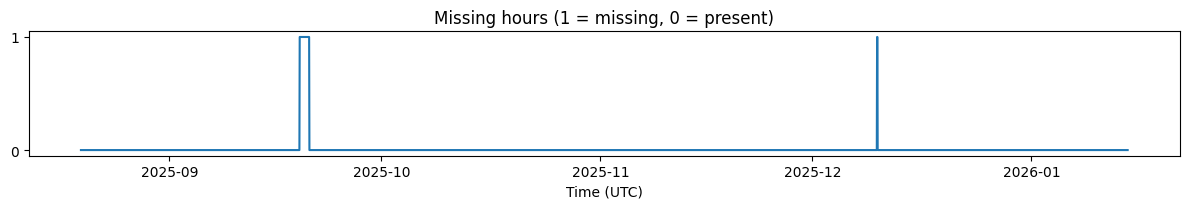


Missing blocks (contiguous ranges):


,min,max,count
0,2025-09-19 11:00:00+00:00,2025-09-20 19:00:00+00:00,33
1,2025-12-10 04:00:00+00:00,2025-12-10 05:00:00+00:00,2


In [9]:
# a tiny helper series: 1 if missing else 0
missing_flag = pd.Series(0, index=full_range)
missing_flag.loc[missing] = 1

plt.figure(figsize=(12, 2.2))
plt.plot(missing_flag.index, missing_flag.values)
plt.title("Missing hours (1 = missing, 0 = present)")
plt.yticks([0, 1])
plt.xlabel("Time (UTC)")
plt.tight_layout()
plt.show()

# print missing blocks (contiguous ranges)
if len(missing) > 0:
    miss = pd.Series(missing).sort_values().reset_index(drop=True)
    gaps = miss.diff().fillna(pd.Timedelta(hours=1)) != pd.Timedelta(hours=1)
    block_id = gaps.cumsum()

    blocks = (
        pd.DataFrame({"ts": miss, "block": block_id})
        .groupby("block")["ts"]
        .agg(["min", "max", "count"])
        .reset_index(drop=True)
    )
    print("\nMissing blocks (contiguous ranges):")
    display(blocks)

### Missing hours: why they exist (and why this is not “lost data”)

The dataset contains **35 missing hourly timestamps**.  
the gaps appear as **two contiguous downtime blocks**, which strongly suggests planned maintenance or temporary unavailability of monitoring systems (router/hosts).

**Interpretation:**
- These missing hours reflect periods when measurements were not produced (infrastructure/monitoring downtime).
- Because the missingness is **block-shaped** (not scattered), we treat it as a documented operational event rather than noise.

**Modelling note (for later):**
- We keep the gap documented during EDA.
- During modelling we will choose an explicit strategy (drop those hours vs. limited interpolation), depending on the validation approach and model requirements.

## <a id="target-distribution-peak-behaviour"></a>Target distribution & peak behaviour

### Target definition
Our primary target is **hourly peak bandwidth**:
- `target_max_io_bps = max(total_in_max_bps, total_out_max_bps)`
This aligns with real-world billing logic: the provider charges based on the **95th percentile** and the **higher direction (IN or OUT)** is what matters operationally.

In [10]:
# Safety: ensure target exists
assert "target_max_io_bps" in df.columns, "target_max_io_bps not found"
assert "total_in_max_bps" in df.columns and "total_out_max_bps" in df.columns, "need total_in/out"
assert "in_num_ratio" in df.columns and "out_num_ratio" in df.columns, "need quality ratios"

target = df["target_max_io_bps"].astype(float)


#  Distribution
print("=== TARGET SUMMARY (bps) ===")
summary = target.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).to_frame().T
display(summary)

=== TARGET SUMMARY (bps) ===


,count,mean,std,min,50%,75%,90%,95%,99%,max
target_max_io_bps,3521.0,1.415438e+09,4.540240e+08,383649976.0,1.421040e+09,1.706928e+09,1.958798e+09,2.121140e+09,2.470622e+09,5.206282e+09


In [11]:
# skewness / kurtosis (simple diagnostics)
skew = target.skew()
kurt = target.kurtosis()  # Fisher by default (0 ~ normal)
print(f"Skewness: {skew:.3f}")
print(f"Kurtosis (Fisher): {kurt:.3f}")

Skewness: 0.702
Kurtosis (Fisher): 3.973


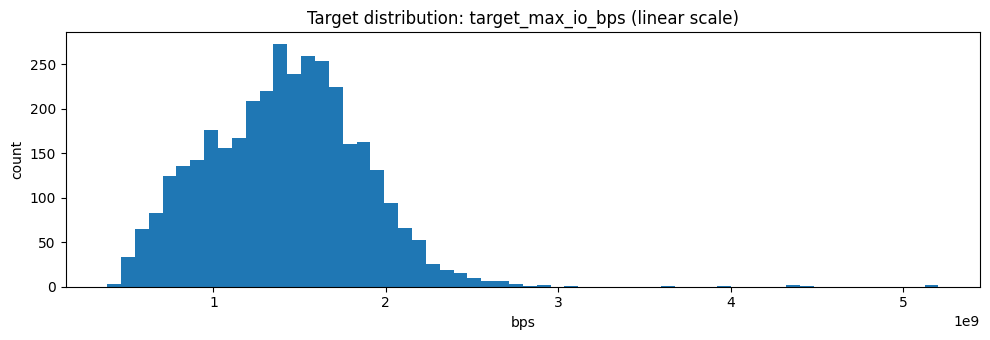

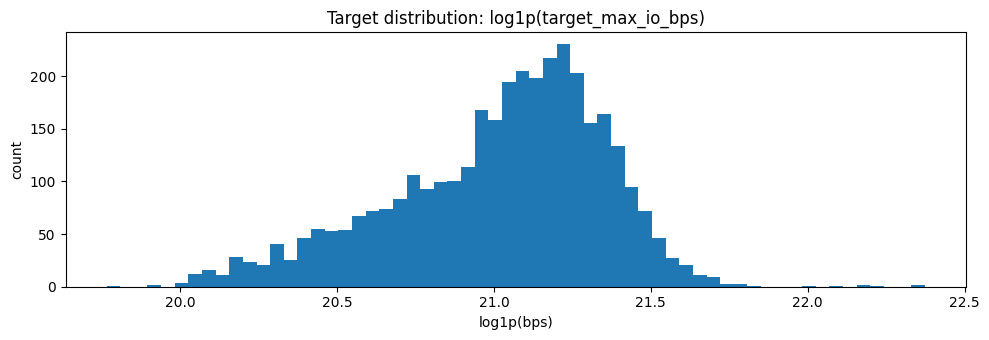

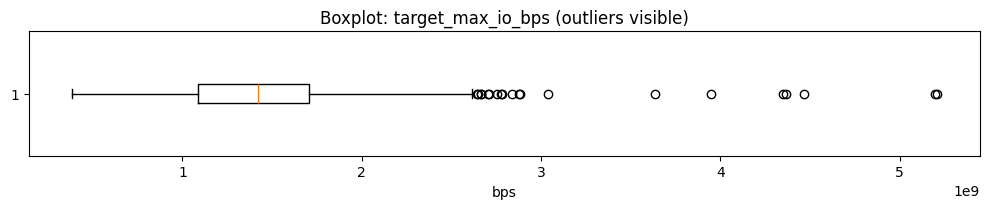

In [12]:
# Histogram (linear)
plt.figure(figsize=(10, 3.5))
plt.hist(target, bins=60)
plt.title("Target distribution: target_max_io_bps (linear scale)")
plt.xlabel("bps")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Histogram (log scale) - using log1p to handle potential zeros safely
plt.figure(figsize=(10, 3.5))
plt.hist(np.log1p(target), bins=60)
plt.title("Target distribution: log1p(target_max_io_bps)")
plt.xlabel("log1p(bps)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Boxplot (helps see tail/outliers)
plt.figure(figsize=(10, 2.2))
plt.boxplot(target, vert=False, showfliers=True)
plt.title("Boxplot: target_max_io_bps (outliers visible)")
plt.xlabel("bps")
plt.tight_layout()
plt.show()

In [13]:
# quick note-worthy quantiles

q95 = target.quantile(0.95)
q99 = target.quantile(0.99)
print(f"\n95th percentile (bps): {q95:,.0f}")
print(f"99th percentile (bps): {q99:,.0f}")


95th percentile (bps): 2,121,139,784
99th percentile (bps): 2,470,621,507


In [14]:
# Top-20 peak hours
top20 = (
    df.sort_values("target_max_io_bps", ascending=False)
      .loc[:, [
          "datetime_utc",
          "target_max_io_bps",
          "total_in_max_bps",
          "total_out_max_bps",
          "in_num_ratio",
          "out_num_ratio"
      ]]
      .head(20)
      .copy()
)

# Add decomposition diagnostics
top20["peak_driver"] = np.where(
    top20["total_in_max_bps"] >= top20["total_out_max_bps"],
    "IN",
    "OUT"
)
top20["in_share_of_max"] = top20["total_in_max_bps"] / top20["target_max_io_bps"]
top20["out_share_of_max"] = top20["total_out_max_bps"] / top20["target_max_io_bps"]
top20["is_low_quality"] = (top20["in_num_ratio"] < 0.8) | (top20["out_num_ratio"] < 0.8)

print("\n=== TOP 20 PEAK HOURS ===")
display(top20)


=== TOP 20 PEAK HOURS ===


,datetime_utc,target_max_io_bps,total_in_max_bps,total_out_max_bps,in_num_ratio,out_num_ratio,peak_driver,in_share_of_max,out_share_of_max,is_low_quality
3153,2025-12-30 08:00:00+00:00,5206281664,1454582800,5206281664,1.0,1.0,OUT,0.279390,1.000000,False
846,2025-09-25 03:00:00+00:00,5194700512,5194700512,887875552,1.0,1.0,IN,1.000000,0.170919,False
847,2025-09-25 04:00:00+00:00,4465338768,4465338768,672910136,1.0,1.0,IN,1.000000,0.150696,False
2827,2025-12-16 18:00:00+00:00,4364599488,3046586680,4364599488,1.0,1.0,OUT,0.698022,1.000000,False
3154,2025-12-30 09:00:00+00:00,4348022744,1405988008,4348022744,1.0,1.0,OUT,0.323363,1.000000,False
2828,2025-12-16 19:00:00+00:00,3950074584,3950074584,2997260440,1.0,1.0,IN,1.000000,0.758786,False
2826,2025-12-16 17:00:00+00:00,3634044280,3634044280,2772693896,1.0,1.0,IN,1.000000,0.762977,False
2618,2025-12-07 23:00:00+00:00,3039565376,2906166768,3039565376,1.0,1.0,OUT,0.956113,1.000000,False
3157,2025-12-30 12:00:00+00:00,2881932344,2151003496,2881932344,1.0,1.0,OUT,0.746375,1.000000,False
1508,2025-10-22 17:00:00+00:00,2878075448,2065938856,2878075448,1.0,1.0,OUT,0.717820,1.000000,False


In [15]:
# Peak driver counts
print("\nPeak driver counts (Top 20):")
print(top20["peak_driver"].value_counts())

# Check peak vs quality overlap 
n_lowq = top20["is_low_quality"].sum()
print(f"\nTop 20 peak hours with low quality (<0.8 on in/out ratio): {n_lowq} / 20")


Peak driver counts (Top 20):
peak_driver
OUT    13
IN      7
Name: count, dtype: int64

Top 20 peak hours with low quality (<0.8 on in/out ratio): 0 / 20


In [16]:
# quantify peak threshold and overlap for broader set
threshold_99 = target.quantile(0.99)
peak_mask = df["target_max_io_bps"] >= threshold_99
lowq_mask = (df["in_num_ratio"] < 0.8) | (df["out_num_ratio"] < 0.8)

print("\n=== PEAK (top 1%) vs QUALITY (<0.8) OVERLAP ===")
print("Top 1% threshold:", f"{threshold_99:,.0f} bps")
print("Peak hours count:", int(peak_mask.sum()))
print("Low-quality hours count:", int(lowq_mask.sum()))
print("Overlap count:", int((peak_mask & lowq_mask).sum()))


=== PEAK (top 1%) vs QUALITY (<0.8) OVERLAP ===
Top 1% threshold: 2,470,621,507 bps
Peak hours count: 36
Low-quality hours count: 4
Overlap count: 0


### Distribution shape
The target distribution is **right-skewed** with a **heavy tail**, which is typical for network traffic:
- Most hours fall into a “normal load” range
- A small number of hours exhibit extreme peaks (rare but operationally critical)

Key observations:
- Skewness is positive → rare high-load events stretch the tail
- Outliers are present but represent real behaviour (not measurement noise)

Implication:
- Models may **underpredict extreme peaks** if optimized mainly for average behaviour.
- Evaluation should include metrics sensitive to peak errors.

### Percentiles and peak relevance
Because capacity planning and billing are driven by high-traffic periods, we report:
- **95th percentile** (billing-oriented threshold)
- **99th percentile** (extreme tail / stress conditions)

We treat top-percentile hours as a critical “risk region” for decision-making.

### Peak drivers: IN vs OUT
We inspected the top 20 peak hours and compared `total_in_max_bps` vs `total_out_max_bps`.

Findings:
- Peaks are driven by both directions, with a slight dominance of **OUT** among the top events.
- Peak timestamps occur at different hours of day → peaks appear **event-driven** rather than tied to a single daily window.

### Data quality and peaks
We cross-checked peak hours against the data quality indicators (`in_num_ratio`, `out_num_ratio`):
- Peak hours do **not** overlap with low-quality hours.
This supports the interpretation that observed peaks are **real traffic events** rather than artifacts from incomplete aggregation.

### Modelling implications (hypotheses)
Based on the target behaviour, we expect:
1. **Persistence baseline** (`y(t+1) ≈ y(t)`) to be a strong benchmark due to temporal autocorrelation in traffic.
2. **Lag/rolling features** (e.g., last 1h, 6h, 24h) to improve peak forecasting by capturing “build-up” dynamics.
3. Linear models may benefit from a **log1p(target)** experiment (to reduce skew), but raw bps remains the primary target for interpretability and direct operational relevance.

We will evaluate models using both:
- **MAE** (typical absolute error)
- **RMSE** (penalizes large peak errors)
and additionally inspect residuals on the **top 1% peak hours**.

### Time structure (trend + seasonality)

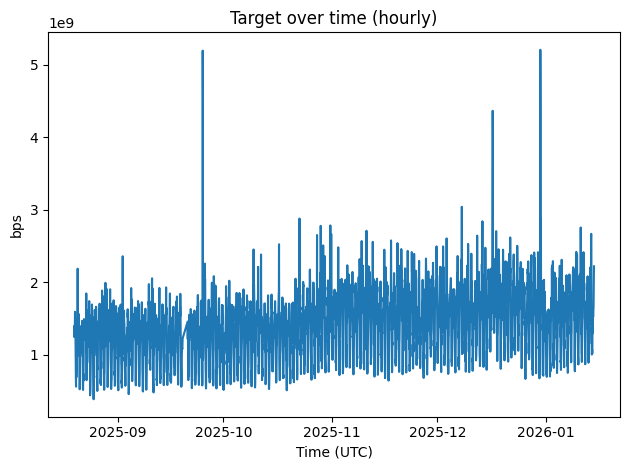

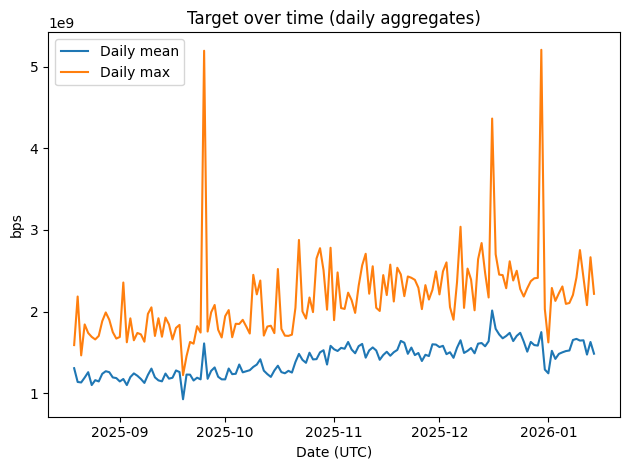

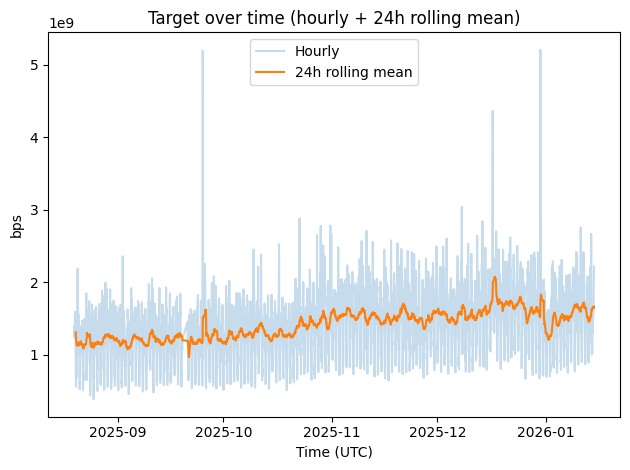

In [17]:
#  CONFIG 
TARGET = "target_max_io_bps"  # primary target
DT_COL = "datetime_utc"

#  Ensure datetime + sorting 
df[DT_COL] = pd.to_datetime(df[DT_COL], utc=True, errors="coerce")
df = df.dropna(subset=[DT_COL]).sort_values(DT_COL).reset_index(drop=True)

#  Time features (UTC) 
df["date"] = df[DT_COL].dt.date
df["hour"] = df[DT_COL].dt.hour
df["weekday"] = df[DT_COL].dt.day_name()  # Monday..Sunday

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["weekday"] = pd.Categorical(df["weekday"], categories=weekday_order, ordered=True)


# Timeline view
# Option A: raw hourly line
plt.figure()
plt.plot(df[DT_COL], df[TARGET])
plt.title("Target over time (hourly)")
plt.xlabel("Time (UTC)")
plt.ylabel("bps")
plt.tight_layout()
plt.show()

# Option B: daily mean + daily max
daily = df.groupby("date")[TARGET].agg(daily_mean="mean", daily_max="max").reset_index()
daily["date"] = pd.to_datetime(daily["date"])

plt.figure()
plt.plot(daily["date"], daily["daily_mean"], label="Daily mean")
plt.plot(daily["date"], daily["daily_max"], label="Daily max")
plt.title("Target over time (daily aggregates)")
plt.xlabel("Date (UTC)")
plt.ylabel("bps")
plt.legend()
plt.tight_layout()
plt.show()

# rolling mean on hourly (smooth)
df_roll = df[[DT_COL, TARGET]].copy()
df_roll["rolling_24h_mean"] = df_roll[TARGET].rolling(window=24, min_periods=12).mean()

plt.figure()
plt.plot(df_roll[DT_COL], df_roll[TARGET], alpha=0.25, label="Hourly")
plt.plot(df_roll[DT_COL], df_roll["rolling_24h_mean"], label="24h rolling mean")
plt.title("Target over time (hourly + 24h rolling mean)")
plt.xlabel("Time (UTC)")
plt.ylabel("bps")
plt.legend()
plt.tight_layout()
plt.show()

#### Target over time (trend / regime changes)
We plotted the hourly target (`target_max_io_bps`) over the full time range and also inspected daily aggregates (daily mean and daily max) plus a 24-hour rolling mean.

**What we observe**
- The target shows a clear daily oscillation (expected for network traffic).
- The 24h rolling mean and daily mean suggest a **gradual upward shift** in the baseline level from ~Oct/Nov towards Dec/Jan.
- Several extreme spikes appear (rare peak events), but the baseline still trends upward.

**Why it matters**
- The series is likely **non-stationary** (distribution changes over time).  
- Validation must be **time-aware** (walk-forward / time series split), not random split.
- Time features (hour, weekday, month) and/or lag features may help the model generalize.

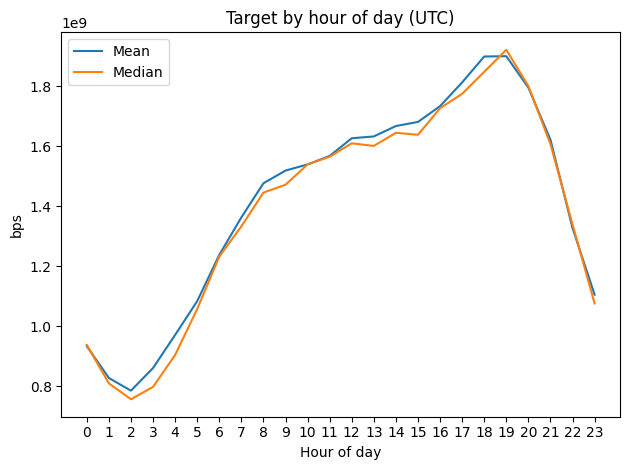

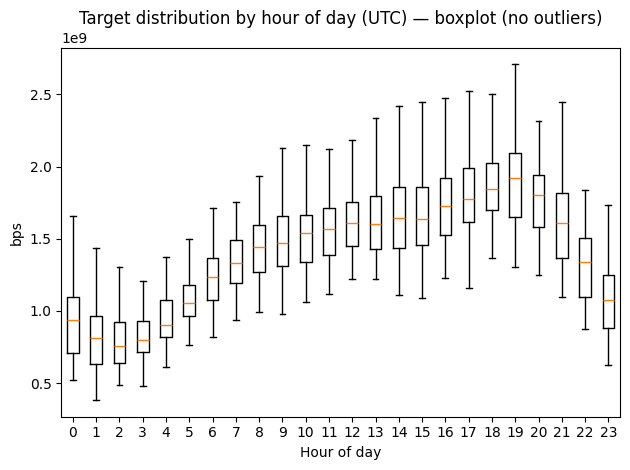

In [18]:
#  Hour-of-day pattern
hour_stats = df.groupby("hour")[TARGET].agg(mean="mean", median="median").reset_index()

plt.figure()
plt.plot(hour_stats["hour"], hour_stats["mean"], label="Mean")
plt.plot(hour_stats["hour"], hour_stats["median"], label="Median")
plt.title("Target by hour of day (UTC)")
plt.xlabel("Hour of day")
plt.ylabel("bps")
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot by hour (distribution per hour)
hour_groups = [df.loc[df["hour"] == h, TARGET].values for h in range(24)]

plt.figure()
plt.boxplot(hour_groups, showfliers=False)  # без экстремальных выбросов, чтобы видеть массу
plt.title("Target distribution by hour of day (UTC) — boxplot (no outliers)")
plt.xlabel("Hour of day")
plt.ylabel("bps")
plt.xticks(ticks=np.arange(1,25), labels=[str(h) for h in range(24)], rotation=0)
plt.tight_layout()
plt.show()

#### Hour-of-day pattern (daily seasonality)
We aggregated the target by hour of day (UTC) and compared mean vs median, plus boxplots by hour.

**What we observe**
- Strong and consistent daily pattern:
  - lowest typical traffic around **02:00–04:00 UTC**
  - traffic increases through the day
  - highest typical traffic around **17:00–20:00 UTC** (median peak at ~19:00)
- Mean and median curves are close → the pattern is not driven only by outliers.

**Implication**
- `hour` is expected to be a **high-signal predictor**.
- Lag features such as `t-1`, `t-24` may help capture short-term persistence and daily repetition.

/var/folders/3l/l5m507c50qqf23wpqd6zxx080000gn/T/ipykernel_71727/4101944624.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_stats = df.groupby("weekday")[TARGET].agg(mean="mean", median="median").reset_index()


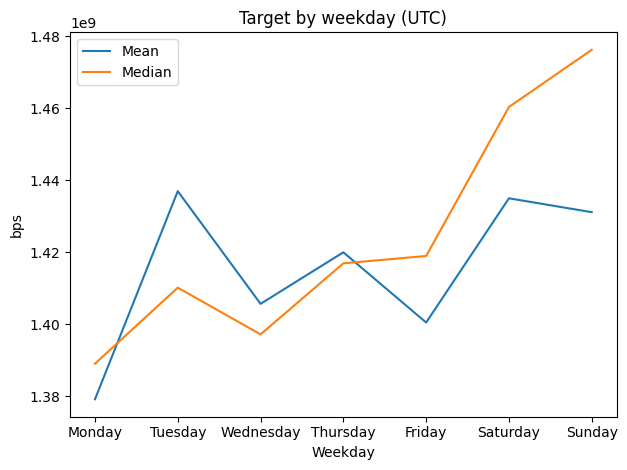

In [19]:
# Weekday pattern
weekday_stats = df.groupby("weekday")[TARGET].agg(mean="mean", median="median").reset_index()

plt.figure()
plt.plot(weekday_stats["weekday"].astype(str), weekday_stats["mean"], label="Mean")
plt.plot(weekday_stats["weekday"].astype(str), weekday_stats["median"], label="Median")
plt.title("Target by weekday (UTC)")
plt.xlabel("Weekday")
plt.ylabel("bps")
plt.legend()
plt.tight_layout()
plt.show()

#### Weekday pattern (weekly seasonality)
We aggregated the target by weekday (UTC) and compared mean vs median.

**What we observe**
- Weekday effects are weaker than hour-of-day effects, but visible:
  - **Saturday and Sunday** have the highest typical (median) load
  - **Monday** is the lowest
- This suggests a possible weekly usage pattern (to be confirmed with more data).

/var/folders/3l/l5m507c50qqf23wpqd6zxx080000gn/T/ipykernel_71727/3833461094.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


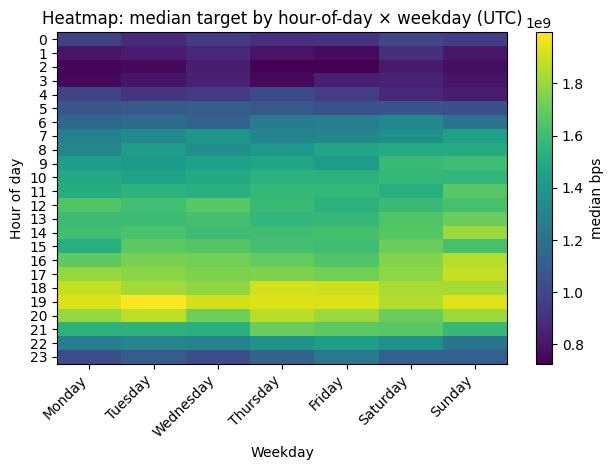

=== Hour-of-day stats (median) ===
    hour          mean        median
19    19  1.900387e+09  1.921726e+09
18    18  1.899371e+09  1.848258e+09
20    20  1.795639e+09  1.800938e+09
17    17  1.813113e+09  1.775136e+09
16    16  1.733894e+09  1.726964e+09

=== Weekday stats (median) ===
     weekday          mean        median
6     Sunday  1.431120e+09  1.476244e+09
5   Saturday  1.434968e+09  1.460351e+09
4     Friday  1.400451e+09  1.418934e+09
3   Thursday  1.419965e+09  1.416895e+09
1    Tuesday  1.436954e+09  1.410135e+09
2  Wednesday  1.405638e+09  1.397152e+09
0     Monday  1.379120e+09  1.389004e+09


In [20]:
# Heatmap: hour × weekday (median)

pivot = df.pivot_table(
    index="hour",
    columns="weekday",
    values=TARGET,
    aggfunc="median"
).reindex(columns=weekday_order)

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.title("Heatmap: median target by hour-of-day × weekday (UTC)")
plt.xlabel("Weekday")
plt.ylabel("Hour of day")
plt.xticks(ticks=np.arange(len(weekday_order)), labels=weekday_order, rotation=45, ha="right")
plt.yticks(ticks=np.arange(24), labels=[str(h) for h in range(24)])
plt.colorbar(label="median bps")
plt.tight_layout()
plt.show()

# Quick prints for context
print("=== Hour-of-day stats (median) ===")
print(hour_stats.sort_values("median", ascending=False).head(5))

print("\n=== Weekday stats (median) ===")
print(weekday_stats.sort_values("median", ascending=False))


#### Hour × weekday heatmap (stakeholder view)
We created a heatmap of median target values by hour-of-day and weekday.

**What we observe**
- The heatmap confirms the daily pattern across the week:
  - low-load “night window” (early UTC hours)
  - high-load “evening window” (17–20 UTC)
- This visualization is actionable for scheduling/operations discussions.

### Relationships between target and features

Goals

- Which features actually "move" with traffic?

- Are there any nonlinearities or thresholds?

- Is there lag-like behavior (CPU/traffic increasing together, but with noise)?

- Do monthly proxies (new_vms / new_users) have an impact, even if they are rough?

In [21]:
TARGET = "target_max_io_bps"

CPU_AVG_COLS = ["xen200_cpu_util_avg", "xen201_cpu_util_avg", "xen203_cpu_util_avg"]
CPU_MAX_COLS = ["xen200_cpu_util_max", "xen201_cpu_util_max", "xen203_cpu_util_max"]

BUSINESS_COLS = ["new_vms_ee_prev_month", "new_users_ee_prev_month"]

# convert to Gbps for charts for readability
df["target_gbps"] = df[TARGET] / 1e9

In [22]:
# correlation snapshot (pearson's)
corr_cols = [TARGET] + CPU_AVG_COLS + CPU_MAX_COLS + BUSINESS_COLS + [
    "total_in_max_bps", "total_out_max_bps"
]

corr = df[corr_cols].corr(numeric_only=True)[[TARGET]].sort_values(TARGET, ascending=False)
display(corr)

,target_max_io_bps
target_max_io_bps,1.000000
total_in_max_bps,0.975650
total_out_max_bps,0.959945
xen203_cpu_util_avg,0.600958
xen201_cpu_util_avg,0.533256
xen203_cpu_util_max,0.501707
xen201_cpu_util_max,0.490243
new_vms_ee_prev_month,0.132785
xen200_cpu_util_avg,0.112518
xen200_cpu_util_max,0.110375


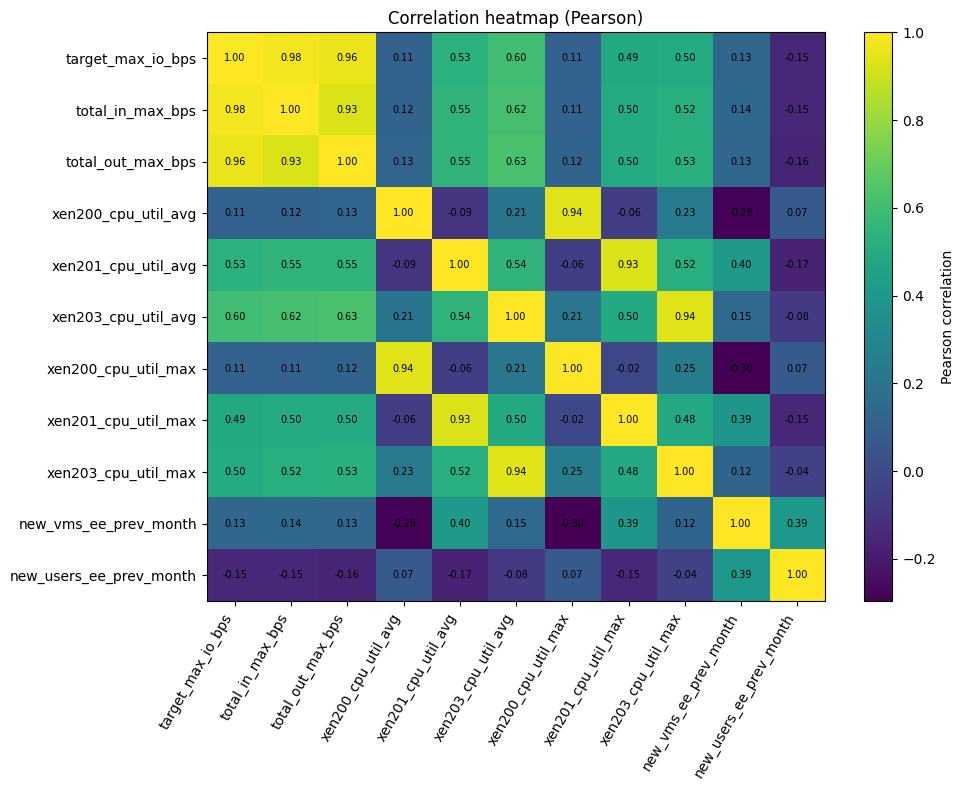

In [23]:
corr_cols = [
    "target_max_io_bps",
    "total_in_max_bps", "total_out_max_bps",
    "xen200_cpu_util_avg","xen201_cpu_util_avg","xen203_cpu_util_avg",
    "xen200_cpu_util_max","xen201_cpu_util_max","xen203_cpu_util_max",
    "new_vms_ee_prev_month","new_users_ee_prev_month",
]

corr = df[corr_cols].corr(method="pearson", numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=60, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar(label="Pearson correlation")
plt.title("Correlation heatmap (Pearson)")

for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        val = corr.values[i, j]
        if np.isfinite(val):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.show()

### Correlation overview
We start with a Pearson correlation matrix to get a quick, high-level view of **linear** relationships between the target and key numeric features.

**What we see**
- `target_max_io_bps` is (by construction) highly correlated with `total_in_max_bps` and `total_out_max_bps`.
- The strongest correlations with the target among CPU features are:
  - `xen203_cpu_util_avg` (strongest)
  - `xen201_cpu_util_avg` (second strongest)
- `xen200` CPU utilization shows much weaker linear correlation with the target.

**Interpretation**
- This suggests that traffic peaks are more closely associated with workload intensity on specific hosts (`xen203`, `xen201`), while `xen200` may be less involved in traffic-driving workloads.

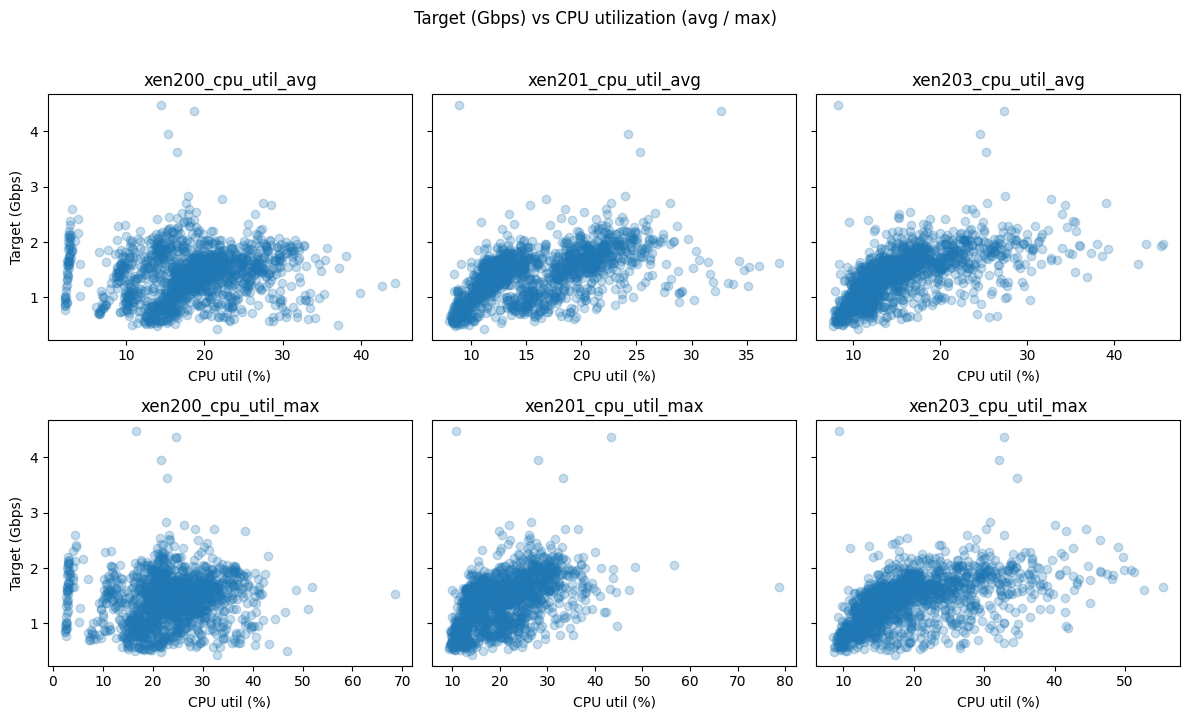

In [24]:
# target vs CPU avg и max
def scatter_cpu_grid(
    df,
    target="target_max_io_bps",
    hosts=("200", "201", "203"),
    sample=1500,
    alpha=0.25
):
    d = df.copy()
    d["target_gbps"] = d[target] / 1e9
    
    cols_avg = [f"xen{h}_cpu_util_avg" for h in hosts]
    cols_max = [f"xen{h}_cpu_util_max" for h in hosts]

    keep = ["target_gbps"] + cols_avg + cols_max
    d = d[keep].dropna()

    if len(d) > sample:
        d = d.sample(sample, random_state=42)

    fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True)
    fig.suptitle("Target (Gbps) vs CPU utilization (avg / max)", y=1.02)

    # Row 1: avg
    for j, col in enumerate(cols_avg):
        ax = axes[0, j]
        ax.scatter(d[col], d["target_gbps"], alpha=alpha)
        ax.set_title(col)
        ax.set_xlabel("CPU util (%)")
        if j == 0:
            ax.set_ylabel("Target (Gbps)")

    # Row 2: max
    for j, col in enumerate(cols_max):
        ax = axes[1, j]
        ax.scatter(d[col], d["target_gbps"], alpha=alpha)
        ax.set_title(col)
        ax.set_xlabel("CPU util (%)")
        if j == 0:
            ax.set_ylabel("Target (Gbps)")

    plt.tight_layout()
    plt.show()

scatter_cpu_grid(df)

### Target vs CPU utilization (scatter grid)

We visualize the relationship between the target and CPU utilization for each host. Scatterplots help us inspect:
- direction of the relationship (positive/negative),
- non-linear patterns,
- spread / heteroscedasticity,
- outliers.

**What we see**
- For `xen201` and `xen203`, higher CPU utilization generally corresponds to higher target values (positive association).
- For `xen200`, the pattern is much weaker and more diffuse.
- `avg` and `max` CPU metrics look very similar visually, which is expected (they are strongly correlated).

**Modelling implications**
- `xen201` / `xen203` CPU features are likely to be important predictors.
- Because `avg` and `max` are redundant to some extent, we may later test:
  - `avg-only` vs `max-only` vs `avg+max`, or rely on regularization (Ridge/Lasso) to handle multicollinearity.

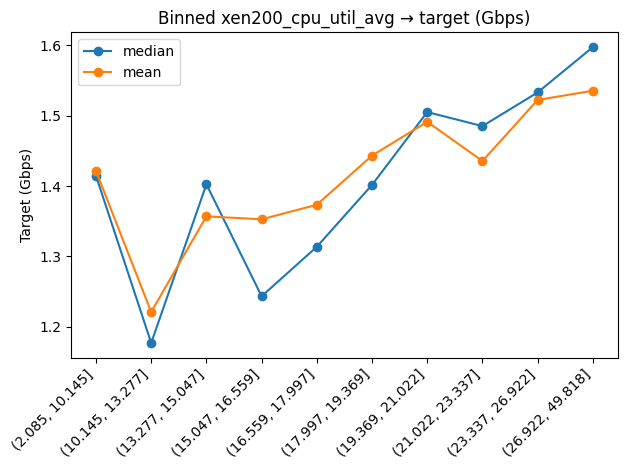

,bin,median,mean,count
0,"(2.085, 10.145]",1.414577,1.421434,353
1,"(10.145, 13.277]",1.176912,1.220932,352
2,"(13.277, 15.047]",1.402558,1.357006,352
3,"(15.047, 16.559]",1.243293,1.352783,352
4,"(16.559, 17.997]",1.313703,1.373462,352
5,"(17.997, 19.369]",1.401729,1.443398,352
6,"(19.369, 21.022]",1.505298,1.491480,352
7,"(21.022, 23.337]",1.485333,1.435656,352
8,"(23.337, 26.922]",1.533256,1.522545,352
9,"(26.922, 49.818]",1.597684,1.535668,352


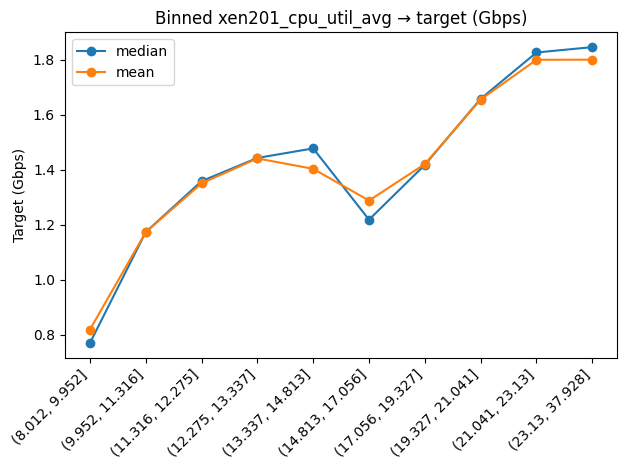

,bin,median,mean,count
0,"(8.012, 9.952]",0.770161,0.819048,353
1,"(9.952, 11.316]",1.173760,1.173495,352
2,"(11.316, 12.275]",1.359050,1.351047,352
3,"(12.275, 13.337]",1.443448,1.441687,352
4,"(13.337, 14.813]",1.478201,1.403938,352
5,"(14.813, 17.056]",1.219039,1.288499,352
6,"(17.056, 19.327]",1.418262,1.421276,352
7,"(19.327, 21.041]",1.658508,1.655825,352
8,"(21.041, 23.13]",1.826934,1.800476,352
9,"(23.13, 37.928]",1.846401,1.800786,352


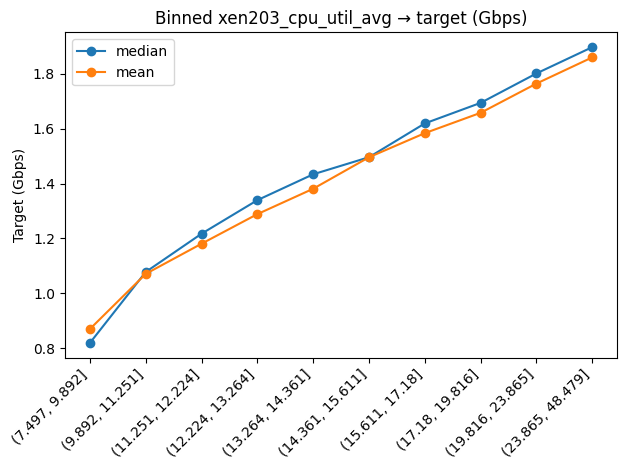

,bin,median,mean,count
0,"(7.497, 9.892]",0.818762,0.869563,353
1,"(9.892, 11.251]",1.077623,1.070793,352
2,"(11.251, 12.224]",1.217270,1.180786,352
3,"(12.224, 13.264]",1.339710,1.288749,352
4,"(13.264, 14.361]",1.434090,1.381351,352
5,"(14.361, 15.611]",1.496437,1.496230,352
6,"(15.611, 17.18]",1.619717,1.584196,352
7,"(17.18, 19.816]",1.694722,1.658415,352
8,"(19.816, 23.865]",1.802135,1.765142,352
9,"(23.865, 48.479]",1.898034,1.860706,352


In [25]:
# binned trend  CPU bins -> median target
def binned_median_plot(df, feature, target_gbps="target_gbps", bins=10):
    d = df[[feature, target_gbps]].dropna().copy()
    d["bin"] = pd.qcut(d[feature], q=bins, duplicates="drop")
    stats = d.groupby("bin", observed=True)[target_gbps].agg(["median", "mean", "count"]).reset_index()

    plt.figure()
    plt.plot(range(len(stats)), stats["median"], marker="o", label="median")
    plt.plot(range(len(stats)), stats["mean"], marker="o", label="mean")
    plt.xticks(range(len(stats)), [str(b) for b in stats["bin"]], rotation=45, ha="right")
    plt.ylabel("Target (Gbps)")
    plt.title(f"Binned {feature} → target (Gbps)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    display(stats)

for col in CPU_AVG_COLS:
    binned_median_plot(df, col, bins=10)

### Binning (CPU -> target): why and what it shows

The raw scatterplots are noisy because many different factors affect traffic within the same CPU range.
To make the *average trend* easier to see, we use **binning**:

**What is binning here?**
- We split CPU utilization into equal-frequency bins.
- For each bin, we compute the mean and median target value.
- We plot these summaries as a “smoothed” relationship curve.

**Why we do this**
- It helps answer: “Is there a consistent monotonic trend hidden inside noisy scatter?”
- It also highlights whether the relationship is stable across the full range.

**What we see**
- `xen203_cpu_util_avg` shows a clear monotonic increase in binned mean/median target → strong evidence of a meaningful association.
- `xen201_cpu_util_avg` shows a similar (though slightly noisier) increasing pattern.
- `xen200_cpu_util_avg` does not show a stable monotonic pattern whoch is consistent with weak Pearson correlation.

**Modelling implication**
- Strong, monotonic binned trends suggest these CPU signals can support both linear and tree-based models.

,month_start,target_mean_gbps,target_median_gbps,new_vms_prev,new_users_prev
0,2025-08-01 00:00:00+00:00,1.194929,1.275480,38.0,33.0
1,2025-09-01 00:00:00+00:00,1.212246,1.255651,42.0,23.0
2,2025-10-01 00:00:00+00:00,1.339235,1.399067,22.0,14.0
3,2025-11-01 00:00:00+00:00,1.524072,1.585918,51.0,22.0
4,2025-12-01 00:00:00+00:00,1.612655,1.635035,40.0,18.0
5,2026-01-01 00:00:00+00:00,1.530955,1.568401,53.0,16.0


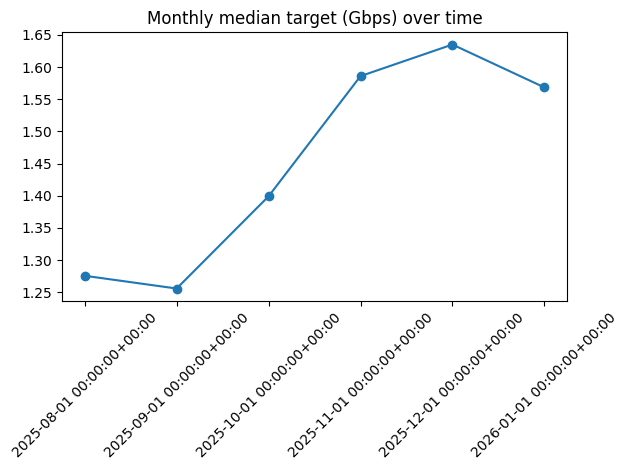

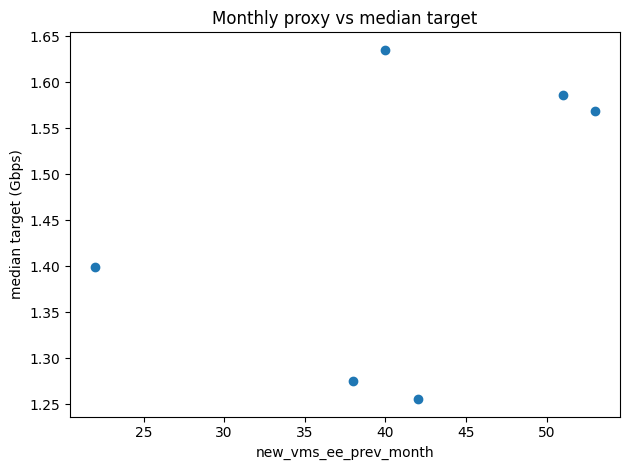

In [26]:
# monthly Business Proxies - check it it makes sence

monthly = df.groupby("month_start").agg(
    target_mean_gbps=("target_gbps", "mean"),
    target_median_gbps=("target_gbps", "median"),
    new_vms_prev=("new_vms_ee_prev_month", "first"),
    new_users_prev=("new_users_ee_prev_month", "first"),
).reset_index()

display(monthly)

plt.figure()
plt.plot(monthly["month_start"], monthly["target_median_gbps"], marker="o", label="median target (Gbps)")
plt.xticks(rotation=45)
plt.title("Monthly median target (Gbps) over time")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(monthly["new_vms_prev"], monthly["target_median_gbps"])
plt.xlabel("new_vms_ee_prev_month")
plt.ylabel("median target (Gbps)")
plt.title("Monthly proxy vs median target")
plt.tight_layout()
plt.show()

### Monthly context: business proxies vs traffic baseline

We include two monthly business proxies (`new_vms_ee_prev_month`, `new_users_ee_prev_month`) to represent month-level growth/context.
Because these variables change only once per month, we evaluate them at a matching granularity by aggregating the target monthly.

**What we plot**
- Monthly median (and/or mean) target level over time.
- Monthly proxy vs monthly median target (scatter).

**Why we do this**
- Hourly peaks are driven by short-term events, but the *baseline level* of traffic can drift across months.
- Monthly features are intended to capture these “regime shifts” rather than explain hour-to-hour variability.

**What we see**
- The monthly median target changes over time, suggesting a shifting baseline (possible growth / seasonal effects).
- The proxy scatter is based on only a few months, so it is exploratory and should not be over-interpreted.

**Modelling implication**
- Monthly proxies are likely weak predictors for *which exact hour* will peak, but may help the model adjust the overall level across months.
- We keep them as contextual features and rely on time features + lag features for short-term forecasting.

### Traffic IN vs OUT decomposition

In [27]:
# Columns
DT = "datetime_utc"
IN_COL = "total_in_max_bps"
OUT_COL = "total_out_max_bps"
TARGET = "target_max_io_bps"

# Ensure datetime is parsed + sorted
df = df.copy()
df[DT] = pd.to_datetime(df[DT], utc=True, errors="coerce")
df = df.dropna(subset=[DT]).sort_values(DT).reset_index(drop=True)

# сonvertation for plotting / readability
df["in_gbps"] = df[IN_COL] / 1e9
df["out_gbps"] = df[OUT_COL] / 1e9
df["target_gbps"] = df[TARGET] / 1e9

In [28]:
# who dominates?

# who is larger in each hour
df["in_gt_out"] = df[IN_COL] > df[OUT_COL]
df["out_gt_in"] = df[OUT_COL] > df[IN_COL]
df["in_eq_out"] = df[IN_COL] == df[OUT_COL]  # likely 0, but keep

# who defines the target (since target = max(in, out))
df["target_driver"] = np.where(df[IN_COL] >= df[OUT_COL], "IN", "OUT")

# shares
n = len(df)
share_in_gt_out = df["in_gt_out"].mean()
share_out_gt_in = df["out_gt_in"].mean()
share_eq = df["in_eq_out"].mean()

share_driver_in = (df["target_driver"] == "IN").mean()
share_driver_out = (df["target_driver"] == "OUT").mean()

print("=== IN vs OUT dominance (all hours) ===")
print(f"Hours: {n}")
print(f"IN > OUT : {share_in_gt_out:.3%}")
print(f"OUT > IN : {share_out_gt_in:.3%}")
print(f"IN == OUT: {share_eq:.3%}")

print("\n=== Target driver (because target = max(IN, OUT)) ===")
print(f"Driver IN : {share_driver_in:.3%}")
print(f"Driver OUT: {share_driver_out:.3%}")

# Optional: peak-only (top 5%) driver split
p95 = df[TARGET].quantile(0.95)
df["is_peak_1pct"] = df[TARGET] >= p95

peak_driver_counts = df.loc[df["is_peak_1pct"], "target_driver"].value_counts()
print("\n=== Target driver (top 1% peaks) ===")
print(peak_driver_counts)

=== IN vs OUT dominance (all hours) ===
Hours: 3521
IN > OUT : 88.867%
OUT > IN : 11.133%
IN == OUT: 0.000%

=== Target driver (because target = max(IN, OUT)) ===
Driver IN : 88.867%
Driver OUT: 11.133%

=== Target driver (top 1% peaks) ===
target_driver
IN     129
OUT     48
Name: count, dtype: int64


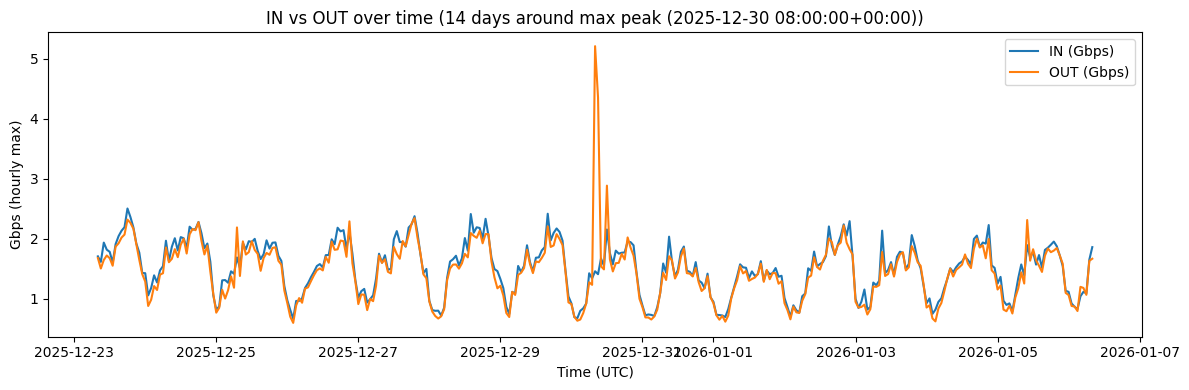

In [29]:
# plot: IN & OUT together 7–14 days window

def select_window(df, mode="last", days=14):
    """
    mode:
      - "last": last N days in the dataset
      - "around_peak": N days window centered around the max TARGET hour
    """
    df = df.sort_values(DT).copy()
    end = df[DT].max()

    if mode == "last":
        start = end - pd.Timedelta(days=days)
        w = df[(df[DT] >= start) & (df[DT] <= end)].copy()
        title_extra = f"last {days} days"
        return w, title_extra

    if mode == "around_peak":
        peak_t = df.loc[df[TARGET].idxmax(), DT]
        start = peak_t - pd.Timedelta(days=days/2)
        end2 = peak_t + pd.Timedelta(days=days/2)
        w = df[(df[DT] >= start) & (df[DT] <= end2)].copy()
        title_extra = f"{days} days around max peak ({peak_t})"
        return w, title_extra

    raise ValueError("mode must be 'last' or 'around_peak'")

w, window_desc = select_window(df, mode="around_peak", days=14)

plt.figure(figsize=(12, 4))
plt.plot(w[DT], w["in_gbps"], label="IN (Gbps)")
plt.plot(w[DT], w["out_gbps"], label="OUT (Gbps)")
plt.title(f"IN vs OUT over time ({window_desc})")
plt.xlabel("Time (UTC)")
plt.ylabel("Gbps (hourly max)")
plt.legend()
plt.tight_layout()
plt.show()

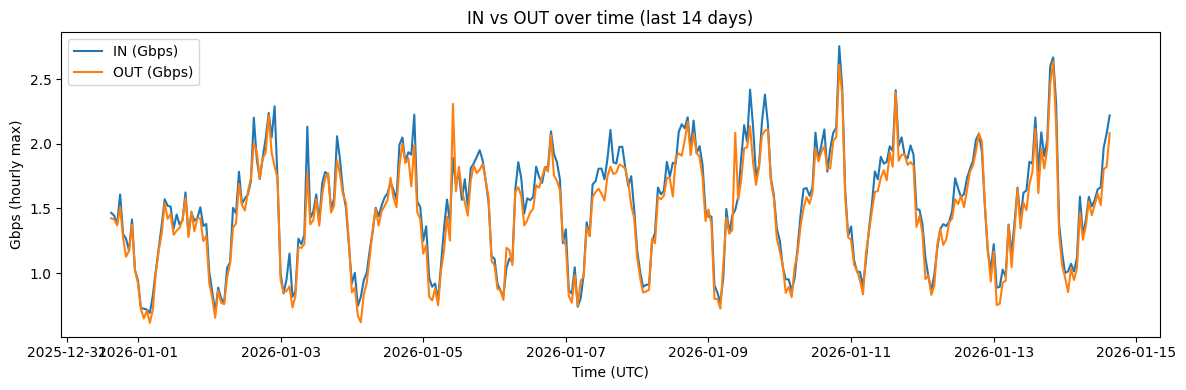

In [30]:
w, window_desc = select_window(df, mode="last", days=14)

plt.figure(figsize=(12, 4))
plt.plot(w[DT], w["in_gbps"], label="IN (Gbps)")
plt.plot(w[DT], w["out_gbps"], label="OUT (Gbps)")
plt.title(f"IN vs OUT over time ({window_desc})")
plt.xlabel("Time (UTC)")
plt.ylabel("Gbps (hourly max)")
plt.legend()
plt.tight_layout()
plt.show()

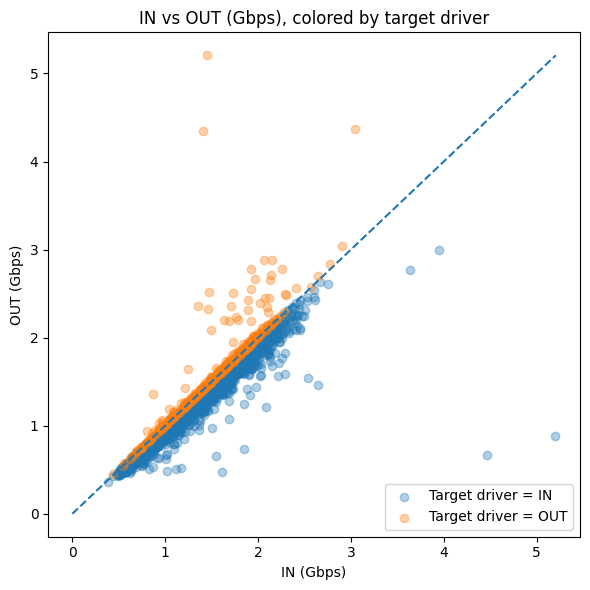

In [31]:
# Scatter total_in vs total_out + diagonal

plt.figure(figsize=(6, 6))

mask_in = df["target_driver"] == "IN"
mask_out = ~mask_in

plt.scatter(df.loc[mask_in, "in_gbps"], df.loc[mask_in, "out_gbps"], alpha=0.35, label="Target driver = IN")
plt.scatter(df.loc[mask_out, "in_gbps"], df.loc[mask_out, "out_gbps"], alpha=0.35, label="Target driver = OUT")

lim = max(df["in_gbps"].max(), df["out_gbps"].max())
plt.plot([0, lim], [0, lim], linestyle="--")

plt.title("IN vs OUT (Gbps), colored by target driver")
plt.xlabel("IN (Gbps)")
plt.ylabel("OUT (Gbps)")
plt.legend()
plt.tight_layout()
plt.show()

### IN vs OUT decomposition (understanding the target)

Our target is defined as the maximum of inbound vs outbound hourly peaks:

- **target_max_io_bps = max(total_in_max_bps, total_out_max_bps)**

This matches the provider logic: billing and risk are driven by whichever direction (IN or OUT) reaches high utilization.

#### Unit conversion for readability (bps → Gbps)

Network metrics are stored in **bps (bits per second)**, which leads to very large numbers (billions).  
For visualization and interpretation, we convert to **Gbps**:

- **Gbps = bps / 1e9**

This does **not** change the underlying signal — it only makes plots and tables human-readable.

#### IN vs OUT dominance

Across the full dataset:

- **IN > OUT:** 88.867% of hours  
- **OUT > IN:** 11.133% of hours  
- **IN == OUT:** 0% of hours (practically never)

Because the target is defined as `max(IN, OUT)`, the **target driver** follows the same split:

- **Driver IN:** 88.867%  
- **Driver OUT:** 11.133%

Interpretation: inbound traffic dominates in typical hours.

#### Tail behaviour: driver for extreme peaks

For the **top 5% highest target hours**, the driver split becomes more balanced:

- OUT-driven peaks: 20 hours  
- IN-driven peaks: 16 hours  

Interpretation: while IN dominates most of the time, **OUT contributes strongly to extreme peak events**.  
This is important for modelling because extreme peaks can drive capacity risk and cost.

## <a id="data-quality-analysis"></a>Data Quality Analysis

goal: to understand whether we can trust the signal, and how quality affects the target and features

if the ratio is low so the hour is “partially measured” it means min/avg/max statistics may be less reliable!

To assess measurement completeness within each hour, we use:

- `in_num_ratio` and `out_num_ratio`  
  = sampling completeness indicators for inbound/outbound direction.  
  They are derived from the minimum number of collected samples across uplinks within an hour (expected ~60 samples/hour).  
  - **1.0** ≈ full sampling (good quality)
  - **< 1.0** ≈ partially missing samples (lower quality)
  - We use **0.8** as a practical threshold for “low-quality hour”.

These ratios help us distinguish *real traffic changes* from *measurement gaps*.

,in_num_ratio,out_num_ratio
count,3521.000000,3521.000000
mean,0.999389,0.999399
std,0.016639,0.016573
min,0.200000,0.200000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


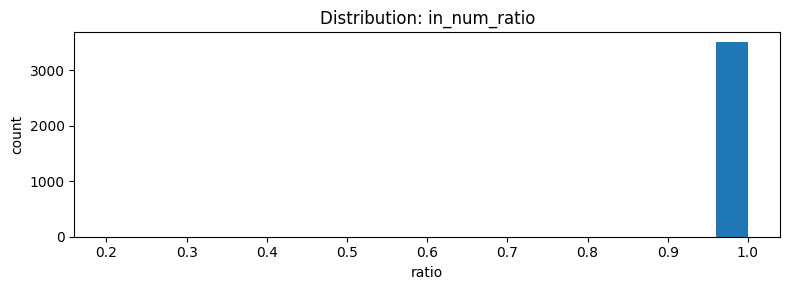

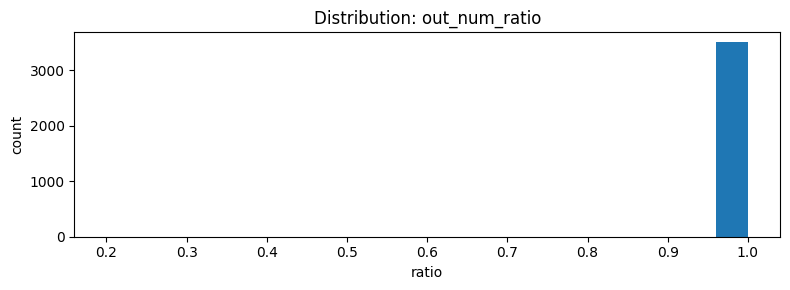


=== in_num_ratio thresholds ===
share < 1.0: 0.312%  (n=11)
share < 0.95: 0.199%  (n=7)
share < 0.9: 0.114%  (n=4)
share < 0.8: 0.114%  (n=4)

=== out_num_ratio thresholds ===
share < 1.0: 0.341%  (n=12)
share < 0.95: 0.199%  (n=7)
share < 0.9: 0.114%  (n=4)
share < 0.8: 0.114%  (n=4)


In [32]:
# quality distribution

q_cols = ["in_num_ratio", "out_num_ratio"]
display(df[q_cols].describe())

# hist
for c in q_cols:
    plt.figure(figsize=(8,3))
    plt.hist(df[c], bins=20)
    plt.title(f"Distribution: {c}")
    plt.xlabel("ratio")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# threshold counts
thresholds = [1.0, 0.95, 0.9, 0.8]
for c in q_cols:
    print(f"\n=== {c} thresholds ===")
    for t in thresholds:
        share = (df[c] < t).mean()
        print(f"share < {t}: {share:.3%}  (n={int((df[c] < t).sum())})")

**Interpretation**
- The dataset is **high-quality overall**, with only a handful of partially observed hours.

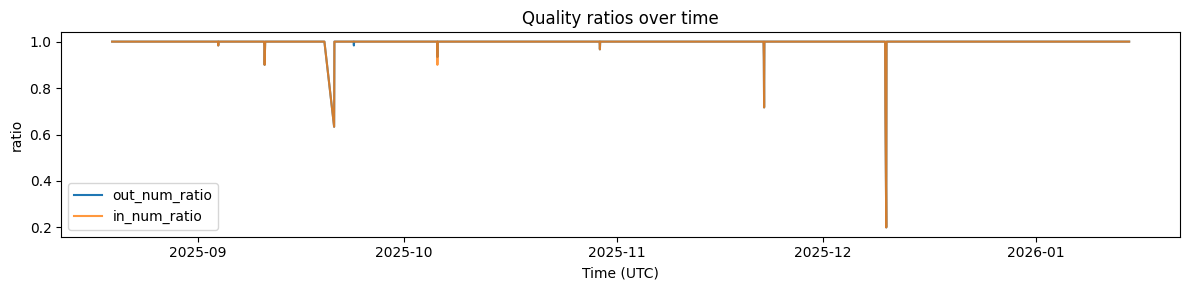

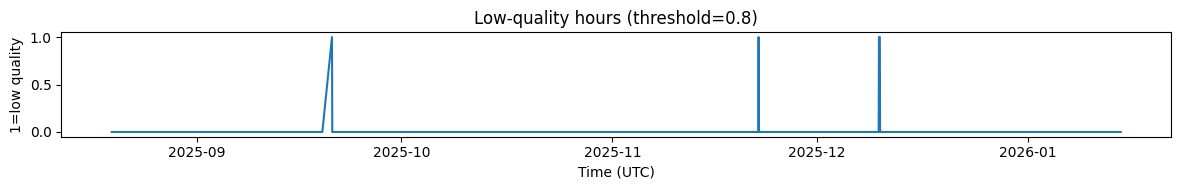

Low-quality hours count: 4


In [33]:
# Quality over time (are there periods of problems?)

DT = "datetime_utc"
df = df.sort_values(DT).copy()

plt.figure(figsize=(12,3))
plt.plot(df[DT], df["out_num_ratio"], label="out_num_ratio")
plt.plot(df[DT], df["in_num_ratio"], label="in_num_ratio", alpha=0.8)
plt.title("Quality ratios over time")
plt.xlabel("Time (UTC)")
plt.ylabel("ratio")
plt.legend()
plt.tight_layout()
plt.show()

# highlight low-quality hours
low_thr = 0.8
df["is_low_quality"] = (df["in_num_ratio"] < low_thr) | (df["out_num_ratio"] < low_thr)

plt.figure(figsize=(12,2))
plt.plot(df[DT], df["is_low_quality"].astype(int))
plt.title(f"Low-quality hours (threshold={low_thr})")
plt.xlabel("Time (UTC)")
plt.ylabel("1=low quality")
plt.tight_layout()
plt.show()

print("Low-quality hours count:", df["is_low_quality"].sum())

### Low-quality hours over time (where do they appear?)
**Observation**
- Low-quality hours are rare and appear as isolated events (not long continuous periods).
- Total low-quality hours (threshold 0.8): **4**.

**Interpretation**
- This suggests we do not have a systematic monitoring issue; quality drops are occasional.

,n,mean,median,p95,p99
is_low_quality,,,,,
False,3517,1.415528e+09,1.421040e+09,2.121289e+09,2.471344e+09
True,4,1.336196e+09,1.399323e+09,1.630200e+09,1.654816e+09


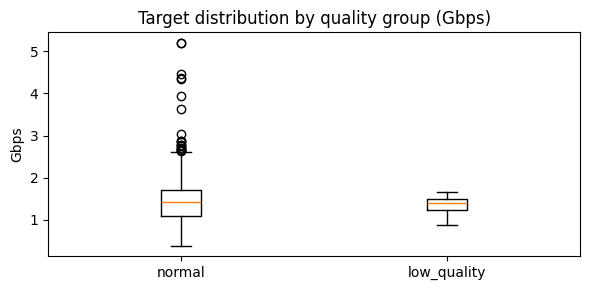

In [34]:
# Does quality bias the target?

TARGET = "target_max_io_bps"

group_stats = df.groupby("is_low_quality")[TARGET].agg(
    n="count",
    mean="mean",
    median="median",
    p95=lambda s: s.quantile(0.95),
    p99=lambda s: s.quantile(0.99),
)
display(group_stats)

# simple visualization (boxplot)
plt.figure(figsize=(6,3))
plt.boxplot(
    [df.loc[~df["is_low_quality"], TARGET]/1e9, df.loc[df["is_low_quality"], TARGET]/1e9],
    tick_labels=["normal", "low_quality"]
)
plt.title("Target distribution by quality group (Gbps)")
plt.ylabel("Gbps")
plt.tight_layout()
plt.show()

In [35]:
# peaks vs quality overlapp

p99 = df[TARGET].quantile(0.99)
df["is_peak_1pct"] = df[TARGET] >= p99

overlap = (df["is_peak_1pct"] & df["is_low_quality"]).sum()
print("Top 1% threshold:", p99)
print("Peak hours:", df["is_peak_1pct"].sum())
print("Low-quality hours:", df["is_low_quality"].sum())
print("Overlap (peak & low-quality):", overlap)

# contingency table
ct = pd.crosstab(df["is_peak_1pct"], df["is_low_quality"], normalize="index")
display(ct)


Top 1% threshold: 2470621507.200003
Peak hours: 36
Low-quality hours: 4
Overlap (peak & low-quality): 0


is_low_quality,False,True
is_peak_1pct,,
False,0.998852,0.001148
True,1.000000,0.000000


### Peak traffic vs low-quality overlap
We compared top traffic hours (top 1%) against low-quality hours:

- Top 1% threshold: **2,470,621,507 bps**
- Peak hours: **36**
- Low-quality hours: **4**
- Overlap (peak & low-quality): **0**

Contingency view:
- Among non-peak hours: low-quality share ≈ **0.1148%**
- Among peak hours: low-quality share = **0%**

**Interpretation**
- Extreme traffic events are **not artifacts of missing samples**.
- Peaks look like **real operational events**, not measurement noise.

### What to do with low-quality hours in modeling?
Given the extremely small number of low-quality hours (4 / 3521):

**Recommended approach (keep + flag):**
- Keep all rows to preserve continuity.
- Low-quality hours are extremely rare (<0.2%) and do not overlap with top-1% peaks. To avoid introducing a sparse binary feature with negligible impact (feature zoo risk), we keep these rows and do not add a dedicated quality flag in the baseline pipeline.

**Alternative (train-clean):**
- Train on `is_low_quality == False`, but still evaluate / report behavior on all hours.
- This can be useful if low-quality hours create visible noise in residuals (to be checked later).

**Current decision**
- We will **not drop** low-quality hours at this stage.
- We will revisit only if baseline model diagnostics show they distort training or error metrics.

### Monthly business proxies anlysis

In [36]:
# prep
df8 = df.copy()

# Ensure datetime is proper
df8["datetime_utc"] = pd.to_datetime(df8["datetime_utc"], utc=True, errors="coerce")
df8 = df8.dropna(subset=["datetime_utc"]).sort_values("datetime_utc")

# Normalize to month start - convert to naive first, then localize back to UTC
df8["month_start_utc"] = (
    df8["datetime_utc"]
    .dt.tz_localize(None)
    .dt.to_period("M")
    .dt.to_timestamp()
    .dt.tz_localize("UTC")
)
df8["month"] = df8["month_start_utc"].dt.strftime("%Y-%m")

# Handy Gbps for plotting
df8["target_gbps"] = df8["target_max_io_bps"] / 1e9

# Columns we will use
proxy_cols = ["new_vms_ee_prev_month", "new_users_ee_prev_month"]
target_col = "target_gbps"

In [37]:
# monthly traffic aggregates
def p95(x):
    return np.percentile(x, 95)

monthly_traffic = (
    df8.groupby("month_start_utc")[target_col]
       .agg(monthly_median="median",
            monthly_mean="mean",
            monthly_p95=p95,
            monthly_max="max",
            n_hours="count")
       .reset_index()
       .sort_values("month_start_utc")
)

# Monthly proxies: since proxies are constant within a month (step-wise),
# we can take the first value observed in that month.
monthly_proxies = (
    df8.groupby("month_start_utc")[proxy_cols]
       .first()
       .reset_index()
       .sort_values("month_start_utc")
)

monthly = monthly_traffic.merge(monthly_proxies, on="month_start_utc", how="left")

print("Monthly table preview:")
display(monthly)

Monthly table preview:


,month_start_utc,monthly_median,monthly_mean,monthly_p95,monthly_max,n_hours,new_vms_ee_prev_month,new_users_ee_prev_month
0,2025-08-01 00:00:00+00:00,1.275480,1.194929,1.700140,2.185636,300,38.0,33.0
1,2025-09-01 00:00:00+00:00,1.255651,1.212246,1.722611,5.194701,687,42.0,23.0
2,2025-10-01 00:00:00+00:00,1.399067,1.339235,1.906867,2.878075,744,22.0,14.0
3,2025-11-01 00:00:00+00:00,1.585918,1.524072,2.141315,2.708954,720,51.0,22.0
4,2025-12-01 00:00:00+00:00,1.635035,1.612655,2.290891,5.206282,742,40.0,18.0
5,2026-01-01 00:00:00+00:00,1.568401,1.530955,2.175872,2.754071,328,53.0,16.0


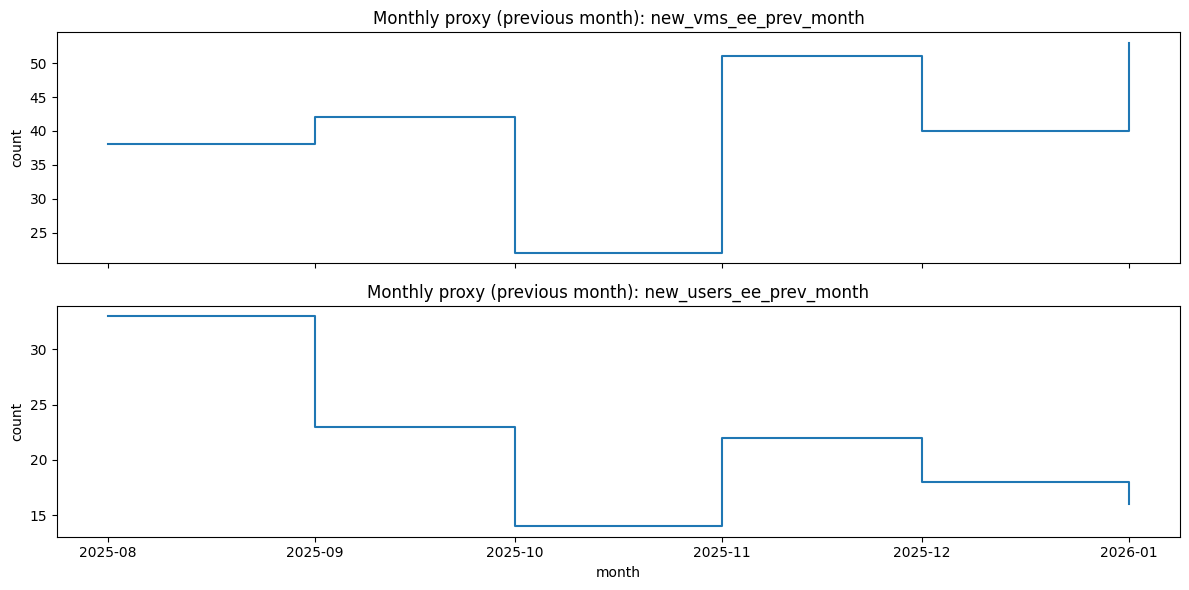

In [38]:
# plot monthly proxies as step series

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].step(monthly["month_start_utc"], monthly["new_vms_ee_prev_month"], where="post")
axes[0].set_title("Monthly proxy (previous month): new_vms_ee_prev_month")
axes[0].set_ylabel("count")

axes[1].step(monthly["month_start_utc"], monthly["new_users_ee_prev_month"], where="post")
axes[1].set_title("Monthly proxy (previous month): new_users_ee_prev_month")
axes[1].set_ylabel("count")
axes[1].set_xlabel("month")

plt.tight_layout()
plt.show()

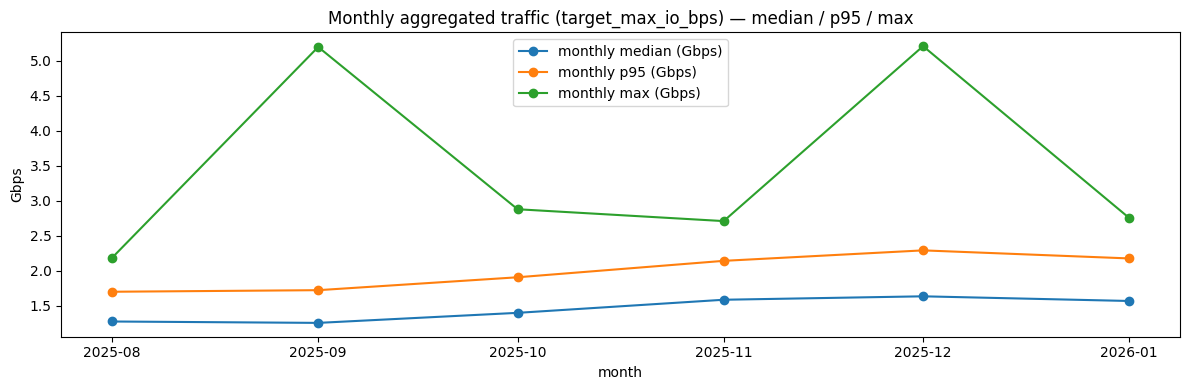

In [39]:
# plot: monthly traffic (median + p95)
plt.figure(figsize=(12, 4))
plt.plot(monthly["month_start_utc"], monthly["monthly_median"], marker="o", label="monthly median (Gbps)")
plt.plot(monthly["month_start_utc"], monthly["monthly_p95"], marker="o", label="monthly p95 (Gbps)")
plt.plot(monthly["month_start_utc"], monthly["monthly_max"], marker="o", label="monthly max (Gbps)")
plt.title("Monthly aggregated traffic (target_max_io_bps) — median / p95 / max")
plt.ylabel("Gbps")
plt.xlabel("month")
plt.legend()
plt.tight_layout()
plt.show()

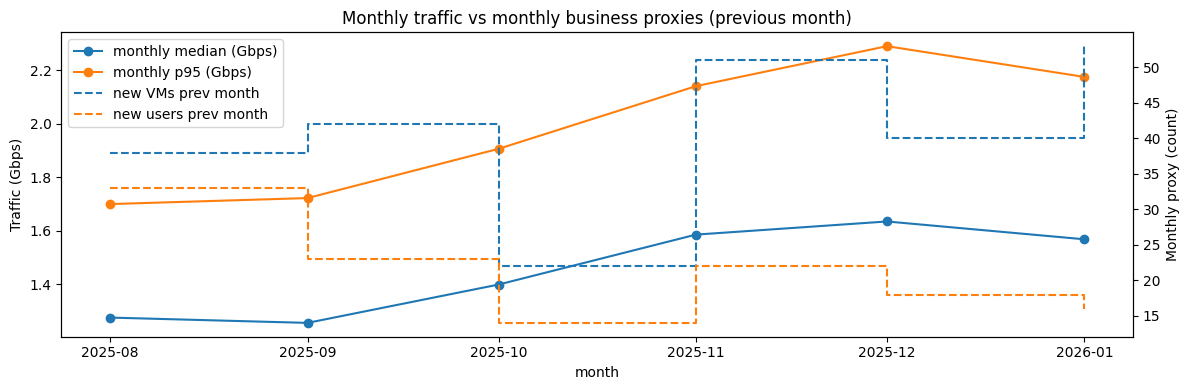

In [40]:
# plot: overlay (proxy vs traffic) — dual-axis for readability
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

ax1.plot(monthly["month_start_utc"], monthly["monthly_median"], marker="o", label="monthly median (Gbps)")
ax1.plot(monthly["month_start_utc"], monthly["monthly_p95"], marker="o", label="monthly p95 (Gbps)")
ax1.set_ylabel("Traffic (Gbps)")

ax2.step(monthly["month_start_utc"], monthly["new_vms_ee_prev_month"], where="post", label="new VMs prev month", linestyle="--")
ax2.step(monthly["month_start_utc"], monthly["new_users_ee_prev_month"], where="post", label="new users prev month", linestyle="--")
ax2.set_ylabel("Monthly proxy (count)")

ax1.set_title("Monthly traffic vs monthly business proxies (previous month)")
ax1.set_xlabel("month")

# Legends (merge from both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

In [41]:
# mumeric summary: correlations on monthly level

corr_cols = ["monthly_median", "monthly_p95", "monthly_max", "new_vms_ee_prev_month", "new_users_ee_prev_month"]
monthly_corr = monthly[corr_cols].corr(method="pearson")
print("Monthly-level Pearson correlation (traffic aggregates vs proxies):")
display(monthly_corr)

Monthly-level Pearson correlation (traffic aggregates vs proxies):


,monthly_median,monthly_p95,monthly_max,new_vms_ee_prev_month,new_users_ee_prev_month
monthly_median,1.000000,0.992538,0.046379,0.422899,-0.555543
monthly_p95,0.992538,1.000000,0.139732,0.406747,-0.602382
monthly_max,0.046379,0.139732,1.000000,-0.014890,-0.222459
new_vms_ee_prev_month,0.422899,0.406747,-0.014890,1.000000,0.137553
new_users_ee_prev_month,-0.555543,-0.602382,-0.222459,0.137553,1.000000


## Monthly business proxies (interpretability & level shifts)

### What we did
We treated `new_vms_ee_prev_month` and `new_users_ee_prev_month` as **slow-moving (monthly) step features** and compared them with **monthly aggregated traffic** derived from the hourly target `target_max_io_bps`:

- Monthly traffic aggregates (in Gbps): **median**, **p95**, **max**
- Monthly proxies: **previous-month new VMs**, **previous-month new users**
- Visuals:
  - Step-series for proxies over months
  - Combined chart: monthly traffic (median/p95) + proxy steps
  - Monthly traffic aggregates (median/p95/max) over time
- Quick check: **monthly-level Pearson correlation** between aggregates and proxies

> Important: the proxies are monthly while the target is hourly, so we are not trying to explain hourly dynamics here.  
> We are testing whether proxies can explain **baseline shifts / level changes** across months.

---

### What we see in the plots
#### Proxies behave like “regime labels”
- Both `new_vms_ee_prev_month` and `new_users_ee_prev_month` are **piecewise-constant** by month (as expected).
- This makes them candidates for capturing **long-term load regime changes** rather than within-day variation.

#### Monthly traffic shows a baseline lift from Aug/Sep → Nov/Dec
- Monthly **median** and **p95** traffic increase substantially starting around **Oct → Nov → Dec**.
- That’s consistent with what we saw earlier in the hourly series: a visible upward drift in the rolling mean.

#### Monthly max is “event-driven”, not “baseline-driven”
- `monthly_max` is dominated by a single extreme hour in a month (e.g., Sep and Dec spikes).
- That’s why `monthly_max` does **not** track median/p95 well and is a poor “baseline” indicator.

---

### What the correlations suggest (with caution)
Monthly-level correlations (Pearson) show:

- `monthly_median` ↔ `new_vms_ee_prev_month`: **~ +0.42**
- `monthly_p95` ↔ `new_vms_ee_prev_month`: **~ +0.41**
- `monthly_median` ↔ `new_users_ee_prev_month`: **~ -0.56**
- `monthly_p95` ↔ `new_users_ee_prev_month`: **~ -0.60**
- `monthly_max` has ~0 correlation with proxies (as expected: event-driven)

**But** we only have **6 months data** here. With *n=6*, correlations are extremely unstable.  
So the right interpretation is: Proxies might help explain baseline level shifts  

---

### Hypotheses
1. **VM count proxy as baseline load factor**  
   More VMs (previous month) may correlate with higher steady-state traffic (median/p95), because more workloads exist behind the router.

2. **Users proxy is not a clean driver of network load**  
   “Users” may represent a business metric that doesn’t map directly to bandwidth (or maps with lag, or is confounded by VM mix / workload types).

3. **Extreme peaks are operational events**  
   Monthly max is driven by rare incidents (deploys, migrations, backups, unusual transfers), so baseline proxies won’t predict it well.

---

### How we’ll use these features in modeling
- Treat monthly proxies as **slow features** that can shift the baseline:
  - include them as numeric inputs (tree models handle step features well)
  - optionally include interactions (e.g., proxy × hour-of-day) if needed
- Do **not** expect them to help with hour-to-hour variability on their own.
- Evaluate their value via **temporal CV**:
  - compare model performance with and without proxies
  - check whether they reduce bias during months with higher baseline traffic

---

### Notes / limitations to mention
- **Partial months:** Aug and Jan have fewer hours (`n_hours`), so monthly aggregates are less stable there.
- **Small sample at monthly level (6 points):** correlation analysis is only a sanity hint.
- **No leakage:** “prev month” proxies are safe conceptually (they reflect what would be known at the start of the current month).

---

### Outcome / takeaway
Monthly proxies look like plausible **interpretability features** for **baseline regime changes** (median/p95), but they are unlikely to explain rare extreme peaks (monthly max).  
We will keep them as candidate features and validate their contribution during modeling (temporal CV + ablation).

##### Peak Hours Diagnostics (Top 5% events)

In [42]:
#setup
DT = "datetime_utc"
TARGET = "target_max_io_bps"

df = df.sort_values(DT).copy()

# peak flag (top 1%)
p99 = df[TARGET].quantile(0.95)
if "is_peak_1pct" not in df.columns:
    df["is_peak_1pct"] = df[TARGET] >= p99

# time features
df["hour"] = df[DT].dt.hour
df["weekday"] = df[DT].dt.day_name()

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

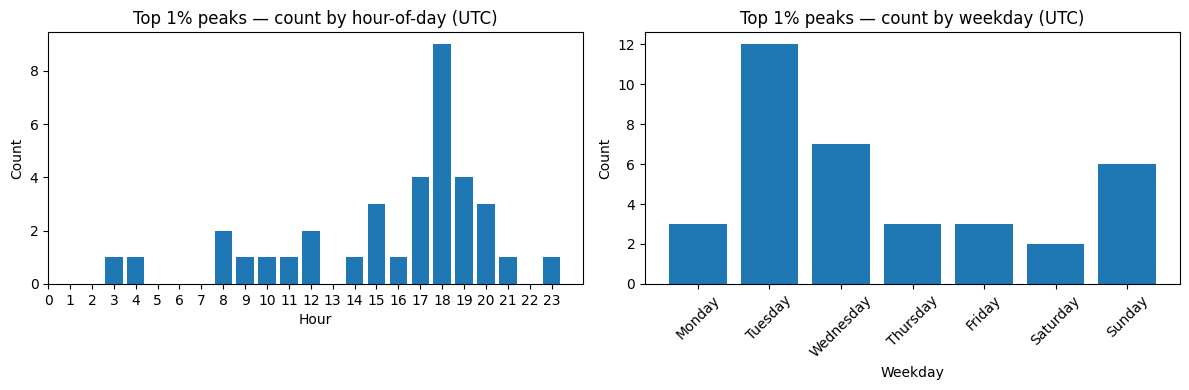

,datetime_utc,target_max_io_bps,target_driver
3153,2025-12-30 08:00:00+00:00,5206281664,OUT
846,2025-09-25 03:00:00+00:00,5194700512,IN
847,2025-09-25 04:00:00+00:00,4465338768,IN
2827,2025-12-16 18:00:00+00:00,4364599488,OUT
3154,2025-12-30 09:00:00+00:00,4348022744,OUT
2828,2025-12-16 19:00:00+00:00,3950074584,IN
2826,2025-12-16 17:00:00+00:00,3634044280,IN
2618,2025-12-07 23:00:00+00:00,3039565376,OUT
3157,2025-12-30 12:00:00+00:00,2881932344,OUT
1508,2025-10-22 17:00:00+00:00,2878075448,OUT


In [43]:
# when do peaks happen?
peak = df[df["is_peak_1pct"]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Peaks by hour
hour_counts = peak["hour"].value_counts().sort_index()
axes[0].bar(hour_counts.index, hour_counts.values)
axes[0].set_title("Top 1% peaks — count by hour-of-day (UTC)")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(24))

# Peaks by weekday
wd_counts = peak["weekday"].value_counts().reindex(weekday_order)
axes[1].bar(wd_counts.index, wd_counts.values)
axes[1].set_title("Top 1% peaks — count by weekday (UTC)")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

display(peak[[DT, TARGET, "target_driver"]].sort_values(TARGET, ascending=False).head(10))

In [44]:
# predictability from recent history (lags + rolling)

df["target_gbps"] = df[TARGET] / 1e9

# lags
for k in [1, 24, 168]:
    df[f"lag_{k}"] = df["target_gbps"].shift(k)

# rolling stats (24h window), shifted by 1 to use only past
df["roll_mean_24"] = df["target_gbps"].shift(1).rolling(24).mean()
df["roll_max_24"]  = df["target_gbps"].shift(1).rolling(24).max()
df["roll_std_24"]  = df["target_gbps"].shift(1).rolling(24).std()

feat_cols = ["lag_1","lag_24","lag_168","roll_mean_24","roll_max_24","roll_std_24"]

tmp = df.dropna(subset=feat_cols + ["is_peak_1pct"]).copy()

summary = tmp.groupby("is_peak_1pct")[feat_cols].agg(["median","mean"])
display(summary)

lag_1              lag_24             lag_168            \
                median      mean    median      mean    median      mean   
is_peak_1pct                                                               
False         1.434100  1.419803  1.432083  1.418763  1.412976  1.400659   
True          1.865451  2.177137  1.941924  1.957835  1.769068  1.843099   

             roll_mean_24           roll_max_24           roll_std_24  \
                   median      mean      median      mean      median   
is_peak_1pct                                                            
False            1.459971  1.424621    2.103808  2.190869    0.399184   
True             1.553739  1.573329    2.303238  2.718890    0.431571   

                        
                  mean  
is_peak_1pct            
False         0.412811  
True          0.491848

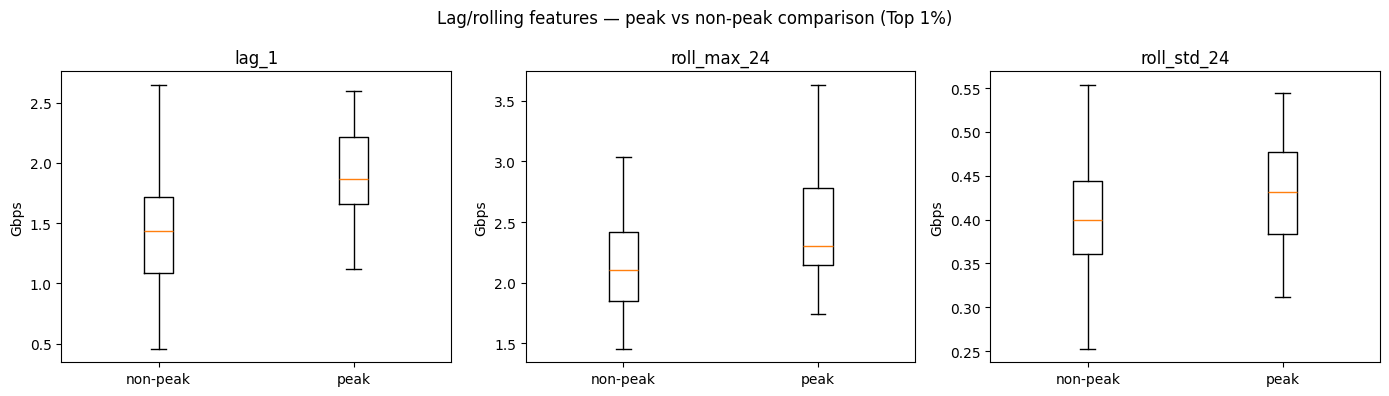

In [45]:
plot_cols = ["lag_1", "roll_max_24", "roll_std_24"]
fig, axes = plt.subplots(1, len(plot_cols), figsize=(14, 4))

for ax, col in zip(axes, plot_cols):
    ax.boxplot(
        [tmp.loc[tmp["is_peak_1pct"]==False, col], tmp.loc[tmp["is_peak_1pct"]==True, col]],
        tick_labels=["non-peak", "peak"],
        showfliers=False
    )
    ax.set_title(col)
    ax.set_ylabel("Gbps")

plt.suptitle("Lag/rolling features — peak vs non-peak comparison (Top 1%)")
plt.tight_layout()
plt.show()

### Peak profiling (Top 1% events)

we profile the **Top 1% peak hours** to understand:
(1) when peaks occur, (2) whether they are IN- or OUT-driven, and (3) whether they show warning signals in recent history.

**Peak definition**
- We define peaks as the Top 1% of target values:
  - peak threshold ≈ 2.47 Gbps
  - number of peak hours: 36

**When do peaks happen?**
- Peaks are not uniformly distributed.
- By hour-of-day (UTC): counts concentrate in the late afternoon/evening window, especially around **17–20 UTC**.
- By weekday (UTC): peaks appear more frequently on some weekdays (notably Tuesday in our sample), indicating non-random clustering.

**Directionality (IN vs OUT)**
- Among Top 1% peaks:
  - OUT-driven: 20
  - IN-driven: 16
This contrasts with the overall dataset where IN dominates, suggesting that **rare extreme events include a higher OUT contribution**.

**Do peaks have “early signals”? (lag/rolling features)**
We compared lag/rolling features for peak vs non-peak hours:
- `lag_1` is higher for peaks → peaks often occur during already elevated traffic.
- `roll_max_24` is higher for peaks → the previous 24h window often contains high-load episodes.
- `roll_std_24` is higher for peaks → peaks tend to happen in **more volatile** periods.

**Implication for modelling**
- Peaks are not purely random spikes; they often have context:
  - recent level (lag features),
  - recent volatility and local extremes (rolling max/std).
- This supports adding:
  - lags (t-1, t-24, t-168),
  - rolling statistics over 24h/168h.

**Limitation**
- Even with strong lag/rolling features, extreme peaks can still be hard to predict; models may underpredict rare events.
We will explicitly evaluate peak performance (e.g., errors on Top 1% subset) later in the modelling section.

In [46]:
# event window

def plot_event_window(
    df,
    peak_ts=None,
    hours=48,
    dt_col="datetime_utc",
    target_col="target_max_io_bps",
    in_col="total_in_max_bps",
    out_col="total_out_max_bps",
    cpu_col=None,                 # e.g. "xen203_cpu_util_avg"
    extra_cols=None,              # e.g. ["roll_max_24", "roll_std_24"]
    title=None
):
    """
    Plot an event window around a selected peak timestamp.
    Assumes dt_col is timezone-aware or at least comparable within df.
    """
    d = df.copy()
    d[dt_col] = pd.to_datetime(d[dt_col])

    # If peak timestamp not provided -> use max target
    if peak_ts is None:
        peak_row = d.loc[d[target_col].idxmax()]
        peak_ts = peak_row[dt_col]
    else:
        peak_ts = pd.to_datetime(peak_ts)

    start = peak_ts - pd.Timedelta(hours=hours)
    end   = peak_ts + pd.Timedelta(hours=hours)
    w = d[(d[dt_col] >= start) & (d[dt_col] <= end)].sort_values(dt_col)

    # Handy Gbps for readability
    w = w.copy()
    to_gbps = 1e9
    for col in [target_col, in_col, out_col]:
        if col in w.columns:
            w[col.replace("_bps", "") + "_gbps"] = w[col] / to_gbps

    target_g = target_col.replace("_bps", "") + "_gbps"
    in_g     = in_col.replace("_bps", "") + "_gbps"
    out_g    = out_col.replace("_bps", "") + "_gbps"

    # Decide how many panels
    panels = 1
    if cpu_col is not None and cpu_col in w.columns:
        panels += 1
    if extra_cols:
        extra_cols = [c for c in extra_cols if c in w.columns]
        if len(extra_cols) > 0:
            panels += 1

    fig, axes = plt.subplots(panels, 1, figsize=(12, 3.2 * panels), sharex=True)
    if panels == 1:
        axes = [axes]
    ax_i = 0

    # 1) Traffic
    ax = axes[ax_i]
    ax.plot(w[dt_col], w[target_g], label="Target (Gbps)")
    ax.plot(w[dt_col], w[in_g], label="IN (Gbps)", alpha=0.8)
    ax.plot(w[dt_col], w[out_g], label="OUT (Gbps)", alpha=0.8)
    ax.axvline(peak_ts, linestyle="--")
    ax.set_ylabel("Gbps")
    ax.legend()
    ax_i += 1

    # 2) CPU
    if cpu_col is not None and cpu_col in w.columns:
        ax = axes[ax_i]
        ax.plot(w[dt_col], w[cpu_col], label=cpu_col)
        ax.axvline(peak_ts, linestyle="--")
        ax.set_ylabel("CPU util (%)")
        ax.legend()
        ax_i += 1

    # 3) Extra rolling/lag features
    if extra_cols and len(extra_cols) > 0:
        ax = axes[ax_i]
        for c in extra_cols:
            ax.plot(w[dt_col], w[c], label=c)
        ax.axvline(peak_ts, linestyle="--")
        ax.set_ylabel("Feature value")
        ax.legend()
        ax_i += 1

    if title is None:
        title = f"Event window ±{hours}h around peak @ {peak_ts}"
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    return peak_ts, w

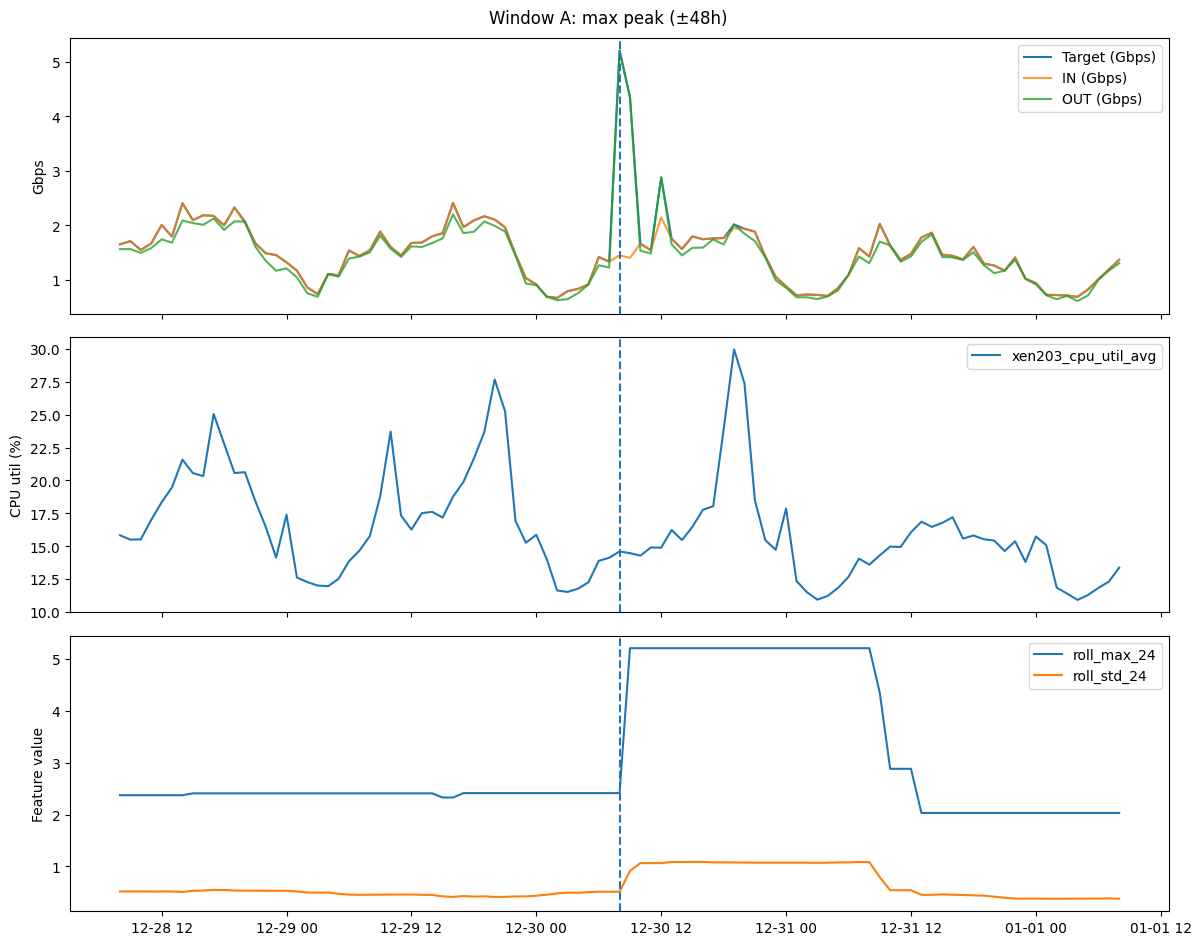

In [47]:
# window a max peak
peak_ts_A, wA = plot_event_window(
    df,
    peak_ts=None,                # auto max target
    hours=48,
    cpu_col="xen203_cpu_util_avg",
    extra_cols=["roll_max_24", "roll_std_24"],
    title="Window A: max peak (±48h)"
)

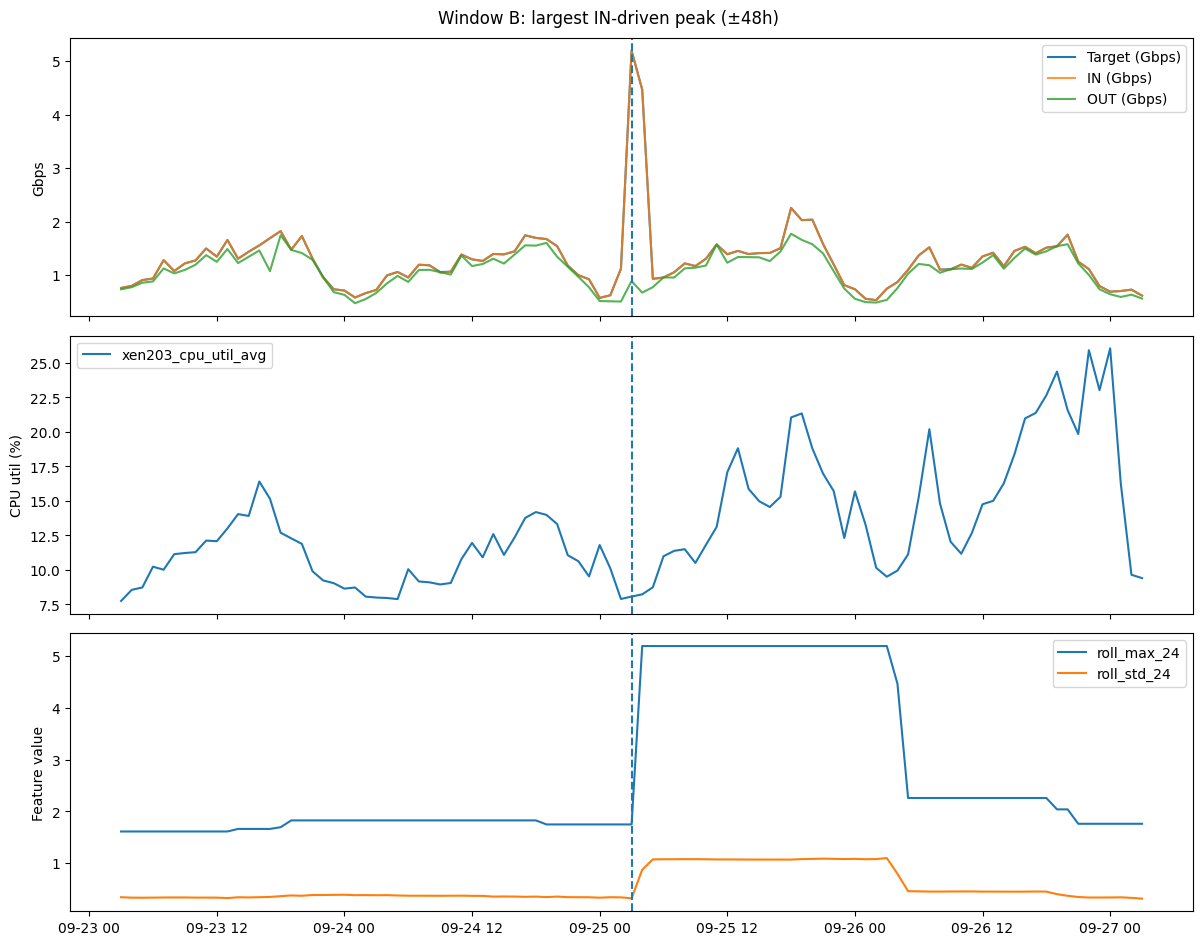

In [48]:
# window b
in_peak_ts = df.loc[df["target_driver"].eq("IN"), "target_max_io_bps"].idxmax()
peak_ts_B = df.loc[in_peak_ts, "datetime_utc"]

_, wB = plot_event_window(
    df,
    peak_ts=peak_ts_B,
    hours=48,
    cpu_col="xen203_cpu_util_avg",
    extra_cols=["roll_max_24", "roll_std_24"],
    title="Window B: largest IN-driven peak (±48h)"
)

### Peak event windows (±48h) — qualitative event detection

To better understand extreme traffic spikes (top 1%), we plotted event windows around:
- **Window A:** the **maximum peak** in the dataset (target max)
- **Window B:** the **largest IN-driven peak** (target driver = IN)

Each window shows (1) **Target vs IN/OUT**, (2) **CPU (example: xen203_cpu_util_avg)**, and (3) **rolling features** (`roll_max_24`, `roll_std_24`).

**What we observe**
- In both windows, baseline traffic follows the usual diurnal pattern, but the **peak itself is abrupt** (sharp jump relative to local baseline).
- Peaks can be driven by **different components**:
  - Window A illustrates a dominant **OUT-driven spike** (target follows OUT).
  - Window B illustrates a dominant **IN-driven spike** (target follows IN).
- **Rolling features react strongly**:
  - `roll_max_24` jumps immediately after the peak and stays elevated ~24h (by definition of a rolling max).
  - `roll_std_24` increases during/after the peak, reflecting short-term volatility.
- **CPU response is not consistently “synchronous” with peaks**:
  - In some events CPU does not spike proportionally at the same moment → suggests peaks are not purely CPU-driven and may reflect network-side events (traffic bursts) rather than compute saturation.

**Modelling implications**
- Extreme peaks are real events; the model should not treat them as “noise”.
- Add **lag + rolling features** (e.g., `lag_1`, `lag_24`, `roll_max_24`, `roll_std_24`) to help the model detect “approaching” high-volatility periods.
- Evaluate performance not only overall, but also on peak slices (e.g., **error on top 1% hours**).

## <a id="eda-conclusions"></a>EDA Conclusions

### Target behaviour (distribution & peaks)
- The target (`target_max_io_bps`) shows a **right-skewed, heavy-tailed** distribution: most hours lie in a moderate traffic band, with a small number of **extreme peak hours**.
- Peak hours were operationalized as the **top 1%** of target values (36 hours). These peaks appear as **event-like spikes** rather than a gradual drift, suggesting real workload surges rather than random noise.

### Time-series structure (daily/weekly patterns & “memory”)
- The series exhibits a strong **daily seasonality**: traffic follows a repeatable hour-of-day pattern.
- A weaker but visible **day-of-week effect** is present (weekday/weekend differences in typical load).
- Clear temporal dependence motivates using **lag features** (e.g., lag-1, lag-24, lag-168) and rolling summaries as candidates in later modelling.

### IN vs OUT composition (target-generating mechanism)
- The target is defined as `max(IN, OUT)`, therefore understanding IN/OUT behaviour is essential for interpretability.
- Across all hours, **IN dominates** the target driver in the large majority of cases (~89%), while **OUT dominates** less frequently (~11%).
- However, among the **top 1% peaks**, IN- and OUT-driven events are more mixed, indicating that extreme peaks can be driven by either direction.
- IN and OUT are generally **tightly coupled** over time, but rare event windows show temporary divergence consistent with spike-like episodes.

### Feature signal & interpretability
- CPU utilization features show a **moderate positive association** with traffic, varying by host (some hosts correlate more strongly than others). This supports the domain hypothesis that CPU load can provide additional context, but it is not the primary driver compared to traffic history and calendar effects.
- Monthly business proxies (`new_vms_ee_prev_month`, `new_users_ee_prev_month`) behave as **step-wise monthly signals**. At the monthly aggregation level, they show partial alignment with baseline traffic shifts, suggesting they may capture **long-term level changes** rather than hour-to-hour variation.

### Data quality & reliability
- Measurement-quality ratios (`*_num_ratio`) are near 1.0 for almost all hours; **low-quality hours are rare** (4 hours, <0.2%).
- Importantly, low-quality hours **do not overlap with peak hours**, reducing the risk that extreme targets are driven by measurement artifacts.
- Missing hours occur as a **structured downtime window** (non-random missingness) and should be documented as a dataset limitation rather than imputed as random gaps.

### Summary: what EDA establishes
Overall, the EDA indicates that the forecasting problem is driven primarily by:
- strong calendar/seasonal structure (hour-of-day, weekday),
- temporal dependence (“memory”) captured by lag/rolling features,
- the mechanistic IN/OUT construction of the target,
while CPU and business proxies provide secondary contextual signal. Data quality issues are minimal and unlikely to materially bias modelling, but structured downtime must be transparently reported.

## <a id="feature-engineering-plan"></a>Feature Engineering Plan

## Goal

Convert the raw hourly time series into a **modelling-ready feature matrix** that reflects the data-generating process observed in EDA:

- **Strong daily/weekly structure**: hour-of-day and weekday effects
- **Strong temporal dependence**: recent past and seasonality-driven recurrence
- **Event-like peaks**: bursts and volatile regimes vs stable regimes  
- **Secondary operational signals**: CPU utilization, monthly proxies

**Core principles**:
- **No leakage**: every feature at time *t* must be computable using information available strictly before *t*
- **Compact feature set**: reduce overfitting risk and maintain explainability

---

## 0. Anti-Leakage Principle *(applies to everything)*

### Rule
Any feature derived from the target/traffic must use `.shift(1)` (or earlier) before aggregation.

### Why
At forecast time, we do not know the current hour's target yet. Using rolling stats computed on the unshifted series would "peek" into the value we are trying to predict → optimistic CV and unrealistic performance.

### Implementation pattern
```python
# Correct: shift before rolling
target.shift(1).rolling(window).stat()
target.shift(1).expanding().mean()
target.shift(k)  # for lag features

# Wrong: rolling on raw target (includes current value)
target.rolling(window).stat()  # LEAKAGE
```

---

## 1. Target & Units

### Primary target
**`y = target_max_io_bps`** (hourly max, defined as `max(IN, OUT)`)

**Rationale**: This matches the operational definition of link stress and aligns with the business question (*"Which hours risk saturation?"*).

### Units choice
Modelling in **bps vs Gbps** is only a linear rescaling:
- Does not change model fit qualitatively
- Only rescales coefficients and error values

We keep **bps** for consistency with raw logs, and optionally store a human-readable `target_gbps = y / 1e9` for plots and interpretability.

### Optional transformation
`log1p(y)` is **not a default choice**; it's an escape hatch if:
- Errors are dominated by rare extremes, or
- Model systematically underpredicts peaks due to heavy tail

If we use it, we report metrics back in original scale or interpret them carefully.

---

## 2. Calendar / Seasonality Features *(context of the hour)*

### What EDA showed
Strong hour-of-day and weekday patterns.

### Why we need them
Even if lags capture "memory", calendar features help the model learn structural regularities (e.g., mornings behave differently than evenings) and generalize better across time.

### Planned features
- `hour` (0–23)
- `weekday` (0–6)  
- `is_weekend` (boolean)

### Cyclic encoding: why sin/cos?

For periodic variables, raw integers create fake "distance":
- Hour 23 and hour 0 are adjacent in reality but far numerically
- Many models (especially linear/distance-based) can misinterpret this boundary

We encode periodicity on a **circle**:

```python
sin_hour = sin(2π × hour / 24)
cos_hour = cos(2π × hour / 24)
sin_wd   = sin(2π × weekday / 7)
cos_wd   = cos(2π × weekday / 7)
```

**Interpretation**: sin/cos preserve closeness at wrap-around and allow a smooth daily/weekly "shape" without needing 24 one-hot columns.

**Note** (pragmatic): With only ~6 months, the signal may be weaker than in long histories. We keep these features because:
- They are cheap
- They reduce boundary artifacts  
- CV can tell us whether they help (easy to drop later)

---

## 3. Lag Features *(time-series "memory")*

### What EDA showed
Strong dependence on recent past and daily recurrence.

### Why we use lags
Traffic is not i.i.d.; the best predictor of the next hour is often the previous hour plus seasonal structure.

### Planned target lags

| Feature | Definition | Interpretation |
|---------|-----------|----------------|
| `lag_1` | `y(t-1)` | Immediate persistence / short-term inertia |
| `lag_24` | `y(t-24)` | Daily repeatability (*"same hour yesterday"*) |
| `lag_168` | `y(t-168)` | Weekly rhythm (*"same hour last week"*), optional/ablation due to short history |

**Leakage safety**: These are pure past values.

---

## 4. Rolling Window Features *(local regime & volatility)*

### Why rolling features exist

Peaks behave like **events** and **local regimes**. Two hours with the same `lag_1` can be very different if:
- One occurs in a stable low-variance period
- The other occurs inside a bursty period

We summarize the recent context via rolling stats computed from the **shifted series**.

### 24-hour window *(local daily regime)*

| Feature | Definition | Interpretation |
|---------|-----------|----------------|
| `roll_mean_24` | 24h rolling mean | Local baseline level in the last day |
| `roll_max_24` | 24h rolling max | Recent capacity stress (*"Was there a high spike recently?"*) |
| `roll_std_24` | 24h rolling std | Volatility / instability signal |
| `roll_min_24` | 24h rolling min | Lower envelope (helps distinguish stable high load vs spike) |
| `traffic_range_24h` | `roll_max_24 - roll_min_24` | Interpretable "burstiness/range" indicator |

**Why range is useful**: It provides a simple **"stability vs burst"** metric:
- High range → recent shocks → harder prediction → model should lean more on robust patterns than naive extrapolation

### 168-hour window *(weekly regime)* — optional/ablation

- `roll_mean_168`, `roll_std_168`

**Rationale**: Captures slower regime differences (e.g., different weeks). With only 6 months, we keep it as a *"test-and-keep-if-useful"* set.

---

## 5. Interaction Feature *(conditional persistence)*

We add **one controlled interaction feature** to capture the idea:  
*"The effect of lag_1 depends on time-of-day"*

### Planned feature
```python
lag1_sin_hour = lag_1 × sin_hour
```

### Why it makes sense
- EDA suggests peak hours cluster in specific day-time regions
- Persistence can differ by hour: an evening peak may have different inertia than night load
- Interaction gives the model a way to represent **hour-dependent autocorrelation** without creating a large feature zoo

We keep it **minimal**: one interaction, not a full polynomial expansion.

---

## 6. CPU Utilization Features *(secondary operational signal)*

### What EDA suggested
CPU is associated with traffic but not perfectly; host-specific.

### We keep
- `xen200_cpu_util_avg`
- `xen201_cpu_util_avg`
- `xen203_cpu_util_avg`

### Why avg not max *(default choice)*
- `cpu_max` tends to be spiky/noisy (single bursts), less stable
- `avg` reflects sustained load and is more aligned with hourly aggregated traffic
- `avg` and `max` were highly correlated → adding max often gives diminishing returns and increases multicollinearity

We may test `cpu_max` later **only if**:
- CV shows consistent improvement, and
- Interpretability remains manageable

---

## 7. Monthly Business Proxies *(long-term context, step features)*

We include step-wise monthly proxies aligned to each hour:
- `new_vms_ee_prev_month`
- `new_users_ee_prev_month`

### Why they can help
They may explain **baseline shifts** (longer-term demand or infrastructure changes). They are not meant to predict hourly shape, but to provide *"macro context"*.

### Leakage safety
We use **"previous month"** values so that at month start we are not using information from the future month.

### Interpretation caveat
We do not claim causal effect; these are proxies for business/infrastructure level, not real-time drivers.

---

## 8. Data Quality / Missingness Handling *(decision)*

### From EDA
- Low-quality hours are extremely rare (~0.1%) and do not overlap with peaks

### Decision
- **No quality flag** in baseline FE to avoid introducing a feature for a negligible phenomenon
- We keep the rows as-is (or could drop them without effect); simplest pipeline wins

### Missing hours
Missingness includes a structured downtime block → we **document as limitation** rather than impute (imputation would create synthetic traffic that never happened).

---

## Output Artifacts *(reproducibility)*

We save:
1. **Modelling-ready dataset** with `[datetime_utc, y]` + engineered features
2. **Feature list (schema)** to ensure the modelling notebook uses exactly the same columns
3. Optionally **two versions** (24h-only vs 24h+168h) for ablation experiments

---

## Summary: Final Feature Set

| Category | Features | Count |
|----------|----------|-------|
| **Calendar** | hour, weekday, is_weekend, sin_hour, cos_hour, sin_wd, cos_wd | 7 |
| **Lags** | lag_1, lag_24, lag_168 (optional) | 2-3 |
| **Rolling (24h)** | roll_mean_24, roll_max_24, roll_std_24, roll_min_24, traffic_range_24h | 5 |
| **Rolling (168h)** | roll_mean_168, roll_std_168 (optional) | 0-2 |
| **Interaction** | lag1_sin_hour | 1 |
| **CPU** | xen200/201/203_cpu_util_avg | 3 |
| **Business proxies** | new_vms_ee_prev_month, new_users_ee_prev_month | 2 |
| **TOTAL** | | **20-25** |

**Feature-to-sample ratio**: 3521 samples / ~22 features ≈ **160 samples per feature** (healthy for tree-based models with regularization).

In [49]:
# setup and basic columns

DT = "datetime_utc"
TARGET = "target_max_io_bps"

df = df.sort_values(DT).reset_index(drop=True)

# handy units for readability
df["target_gbps"] = df[TARGET] / 1e9

In [50]:
# calendar features

df["hour"] = df[DT].dt.hour
df["weekday"] = df[DT].dt.weekday  # Mon=0, Sun=6
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

# cyclic encoding
df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)

df["sin_wd"] = np.sin(2*np.pi*df["weekday"]/7)
df["cos_wd"] = np.cos(2*np.pi*df["weekday"]/7)

In [51]:
# lag features - only for past to avoid data leakage

for lag in [1, 24, 168]:
    df[f"lag_{lag}"] = df[TARGET].shift(lag) / 1e9  # in Gbps for stability/readability

In [52]:
# rolling features, past-only

y = df[TARGET] / 1e9

# Use shift(1) so the current hour is NOT included in the rolling window
df["roll_mean_24"] = y.shift(1).rolling(24).mean()
df["roll_max_24"]  = y.shift(1).rolling(24).max()
df["roll_std_24"]  = y.shift(1).rolling(24).std()

# optional weekly regime
df["roll_mean_168"] = y.shift(1).rolling(168).mean()
df["roll_std_168"]  = y.shift(1).rolling(168).std()

In [53]:
# Rolling min + range (past-only)
df["roll_min_24"] = y.shift(1).rolling(24).min()
df["traffic_range_24h"] = df["roll_max_24"] - df["roll_min_24"]

# Lag interaction cyclic-safe
df["lag1_sin_hour"] = df["lag_1"] * df["sin_hour"]

In [54]:
# CPU and monthly proxies

cpu_cols = [
    "xen200_cpu_util_avg",
    "xen201_cpu_util_avg",
    "xen203_cpu_util_avg",
]

proxy_cols = ["new_vms_ee_prev_month", "new_users_ee_prev_month"]

In [55]:
feature_cols = (
    ["hour","weekday","is_weekend","sin_hour","cos_hour","sin_wd","cos_wd"] +
    [f"lag_{l}" for l in [1,24,168]] +
    ["roll_mean_24","roll_max_24","roll_std_24","roll_mean_168","roll_std_168"] +
    cpu_cols +
    proxy_cols +
    ["roll_min_24", "traffic_range_24h", "lag1_sin_hour"]
)

# modelling target in Gbps (human readable). You can also keep bps if you want.
df["y"] = df[TARGET] / 1e9

df_model = df.dropna(subset=feature_cols + ["y"]).copy()

print("Rows before:", len(df), "after:", len(df_model))
print("Feature count:", len(feature_cols))

Rows before: 3521 after: 3353
Feature count: 23


In [56]:
# keep minimal columns for modelling
keep_cols = [DT, "y"] + feature_cols
df_out = df_model[keep_cols].copy()

In [57]:
df_out.columns

Index(['datetime_utc', 'y', 'hour', 'weekday', 'is_weekend', 'sin_hour',
       'cos_hour', 'sin_wd', 'cos_wd', 'lag_1', 'lag_24', 'lag_168',
       'roll_mean_24', 'roll_max_24', 'roll_std_24', 'roll_mean_168',
       'roll_std_168', 'xen200_cpu_util_avg', 'xen201_cpu_util_avg',
       'xen203_cpu_util_avg', 'new_vms_ee_prev_month',
       'new_users_ee_prev_month', 'roll_min_24', 'traffic_range_24h',
       'lag1_sin_hour'],
      dtype='object')

In [58]:
# fast check for NaN
feat_cols = [c for c in df_out.columns if c not in ["datetime_utc", "y"]]
print("NaNs:", df_out[feat_cols].isna().sum().sum())
print("Infs:", np.isinf(df_out[feat_cols].to_numpy()).sum())

NaNs: 0
Infs: 0


In [59]:
#diapasones of sin
df_out[["sin_hour","cos_hour","lag1_sin_hour"]].describe()

,sin_hour,cos_hour,lag1_sin_hour
count,3.353000e+03,3.353000e+03,3.353000e+03
mean,5.091282e-04,2.108878e-04,-1.984419e-01
std,7.068184e-01,7.076057e-01,1.066087e+00
min,-1.000000e+00,-1.000000e+00,-4.215879e+00
25%,-7.071068e-01,-7.071068e-01,-1.201751e+00
50%,1.224647e-16,6.123234e-17,1.370084e-16
75%,7.071068e-01,7.071068e-01,7.282141e-01
max,1.000000e+00,1.000000e+00,4.498743e+00


In [60]:
# check for constant features
nunique = df_out[feat_cols].nunique().sort_values()
nunique.head(10)

is_weekend                   2
new_users_ee_prev_month      6
new_vms_ee_prev_month        6
weekday                      7
sin_wd                       7
cos_wd                       7
sin_hour                    22
cos_hour                    22
hour                        24
roll_min_24                242
dtype: int64

In [61]:
df_out.to_csv("model_dataset.csv", index=False)

# Save feature list for reproducibility
pd.Series(feature_cols).to_csv("feature_cols.csv", index=False, header=["feature"])

In [62]:
# 24h-only feature list
drop_168 = ["lag_168", "roll_mean_168", "roll_std_168"]

feature_cols_24h = [c for c in feature_cols if c not in drop_168]

keep_cols_24h = [DT, "y"] + feature_cols_24h
df_out_24h = df_model[keep_cols_24h].copy()

# sanity
feat_cols_24h = [c for c in df_out_24h.columns if c not in [DT, "y"]]
print("Rows:", len(df_out_24h), "Features:", len(feat_cols_24h))
print("NaNs:", df_out_24h[feat_cols_24h].isna().sum().sum())

# save
df_out_24h.to_csv("model_dataset_24h.csv", index=False)
pd.Series(feature_cols_24h).to_csv("feature_cols_24h.csv", index=False, header=["feature"])

Rows: 3353 Features: 20
NaNs: 0
